# **Basic Well Log Interpretation**
Initial code from https://github.com/petroGG/Basic-Well-Log-Interpretation/tree/master<br>
Further developed by Afgha Izzam Tursina, Pahala Dominicus Sinurat, S.T, M.Sc., Ph.D., and Formation Evaluation Research Team (2022/2023)

# **0. Import Python Library**

In [1]:
# Plotting and Data Manipulation
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import gridspec

# Statistics and Machine Learning
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import scipy
from scipy.signal import savgol_filter

import lasio.examples

# Other
import warnings
warnings.filterwarnings('ignore')


# **1. Change the Format and Combine Multiple Well Data**

### ***1.1. Function for changing the LAS file into TXT***

**Example of a normal LAS file:<br>**
![image.png](attachment:image.png)

**Example of an abnormal LAS file:<br>**
If there are 24 data type curves, it should be distributed over 24 columns x 1 row, but in this example it is distributed over 7 columns x 5 row.

***So curve information rows = 5*** <br>

Example of a abnormal LAS file:
![image-2.png](attachment:image-2.png)


### ***1.2. Convert LAS files into TXT***


#### **1.2.1 Column name adjustments for each well** <br>
Do a rename for columns that don't match the sourcecode. For data columns that are intended to be plotted, they must match as follows:

**Traject 1: GR, CALI, SP**
- GR (Gamma Ray): Gamma ray logging measures the natural radioactivity of the formation. It is useful for differentiating between shale and non-shale rock types since shale typically has a higher gamma ray signature. It's commonly used for correlation and stratigraphic interpretation.
- CALI (Caliper): Caliper logs measure the borehole diameter. They are used to assess the quality of the borehole, identify washouts, and help correct other logs for borehole size effects.
- SP (Spontaneous Potential): The SP log measures the naturally occurring electrical potential difference between the borehole fluid and the formation. It's often used to detect permeable zones, clay boundaries, and stratigraphic changes.

**Traject 2: DR, MR, SR**
- Deep Resistivity (DR), Medium Resistivity (MR), Shallow Resistivity (SR): These resistivity logs  measure the electrical resistivity of the formation at different depths of investigation. They are essential for determining formation water saturation, porosity, and lithology. The deep resistivity log is less affected by invasion of drilling mud, while the shallow resistivity log is more influenced by invasion. There are many tools for measuring resistivity, such as: induction logging tools, laterolog logging tools, microsfl, HDR, Array, etc.

**Traject 3: RHOB, NPHI, DT**
- NPHI (Neutron Porosity): The neutron porosity log measures the hydrogen index of the formation. This is used to estimate porosity by quantifying the amount of hydrogen in the formation, which is indicative of pore space.
- DT (Delta-T or Transit Time): The DT log measures the time it takes for acoustic waves to travel through the formation. It is used to calculate formation porosity and can also help identify lithology changes.
- RHOB (Bulk Density): The bulk density log measures the density of the formation. It's used to estimate porosity, differentiate between rock types, and calculate mineral composition.

In [2]:
def read_las(file, well_name, columns_to_rename, columns_to_keep, keep_original = False):
  file_name = file
  data = lasio.read(file_name).df().reset_index()

  data = data.rename(columns=columns_to_rename)
  data = data.filter(columns_to_keep)

  # Insert Well name columns in the first col index
  data.insert(0, 'WELL', well_name)

  if keep_original:
    data.fillna(-999.25, inplace=True)

  return data

In [5]:
file_name = "../data/raw/ll-4_wire_lima.las"
well_name = "LL-4"
renamed_columns = {'DEPTH' : 'DEPT', 'RT' : 'DR', 'ILM' : 'MR', 'LLS':'SR', 'NPHI_CORR':'NPHI'} # {nama_asli : nama_baru, ... , dst}
columns = ["DEPT","GR", "CALI", "MR", "DR", "SR", "NPHI", "RHOB", "DT", "VSH", "RW", "WELL"]

data = read_las(file_name, well_name, renamed_columns, columns, keep_original = False)

Only engine='normal' can read wrapped files


In [6]:
data.head(100)

WELL  DEPT  GR  CALI  MR  DR  SR  NPHI  RHOB  DT  VSH        RW
0   LL-4   0.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205728
1   LL-4   0.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205695
2   LL-4   1.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205662
3   LL-4   1.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205629
4   LL-4   2.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205596
..   ...   ...  ..   ...  ..  ..  ..   ...   ...  ..  ...       ...
95  LL-4  47.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.202634
96  LL-4  48.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.202602
97  LL-4  48.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.202570
98  LL-4  49.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.202538
99  LL-4  49.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.202506

[100 rows x 12 columns]

In [7]:
data["WELL"].unique()

array(['LL-4'], dtype=object)

# **2. Functions for Data Distribution Plots**

In [8]:
columns_to_plot = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
columns_unit = ["API", "ohm/m", "ohm.m", "v/v", "g/cm³", "v/v", "ohm"]

### ***2.1. Data distribution based on Box Plot***

In [9]:
def boxplot(data):
    # Define the list of columns you want to create subplots for
    columns = columns_to_plot #["GR", "CALI", "SP", "DR", "MR", "SR", "NPHI", "RHOB", "DT"]
    units = columns_unit #["in", "API", "mV", "ohm/m", "ohm.m", "ohm.m", "v/v", "g/cm³", "us/ft"]

    # Get unique wells and assign colors
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))

    # Set the figure size for the overall plot
    plt.figure(figsize=(16, 12))

    # Create subplots for each selected column
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots

        # Plot boxplots for each well with different colors
        for well, color in zip(wells, colors):
            well_data = data[data['WELL'] == well]
            sns.boxplot(x=well_data[column], y=data["WELL"], color=color)

        plt.title(f'Boxplot for {column}', fontsize=12)  # Set the title for the subplot
        plt.xlabel(f'{column} [{units[i-1]}]', fontsize=10)  # Set the x-axis label with the corresponding unit
        plt.ylabel('Frequency', fontsize=10)  # Set the y-axis label as 'Frequency'

    # Add an overall title for the set of subplots
    plt.suptitle("DATA DISTRIBUTION (BOX PLOT)\n", fontsize=16, fontweight='bold')

    # Create a custom legend outside the subplots
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=well, markerfacecolor=color, markersize=10) for well, color in zip(wells, colors)]
    plt.legend(handles=legend_handles, title='WELL', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()



### ***2.2. Data distribution based on Histogram Plot***

In [10]:
def histplot(data):
    # Get unique wells and assign colors
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))

    # Create subplots for histograms
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle('DATA DISTRIBUTION (HISTOGRAM PLOT) \n', fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)

    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)

            # Plot histograms for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[data['WELL'] == well]
                sns.histplot(well_data[column_name].dropna(), bins=50, color=color, ax=ax, kde=True, label=well)

            ax.set_xlabel(f"{column_name} [{column_unit}]")  # Include the specified unit in the x-axis label
            ax.legend(title='WELL')

    # Remove empty subplots if there are more plots than columns
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


### ***2.3. Data distribution based on Density Plot***

In [11]:
def densityplot(data):
    wells = data['WELL'].unique()
    colors = sns.color_palette('viridis', n_colors=len(wells))  # Add this line

    # Group the data by 'WELL' and create subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle('DATA DISTRIBUTION (DENSITY PLOT)\n', fontsize=16)
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)

    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)

            # Plot density plots for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[data['WELL'] == well]
                well_data[column_name].plot(kind='kde', ax=ax, label=well, color=color)

            ax.set_xlabel(f"{column_name} [{column_unit}]")  # Include the specified unit in the x-axis label
            ax.set_ylabel("Frequency")
            ax.legend(title='WELL')

    # Remove any remaining empty subplots
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    plt.tight_layout()
    plt.show()


### ***2.4. Data distribution based on Cross Plot***

In [15]:
def crossplott(logs,x,y,c,x_label,y_label,c_label):
    def scatter_hist(x, y, c, ax, ax_histx, ax_histy, ax_cbar, x_name, y_name, c_name, x_label, y_label, c_label):
        ax_histx.tick_params(axis="x")
        ax_histy.tick_params(axis="y")

        # Remove NaN values from the data
        valid_data_mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(c)
        x = x[valid_data_mask]
        y = y[valid_data_mask]
        c = c[valid_data_mask]

        points = ax.scatter(x, y, c=c, s=50,cmap="viridis", alpha=0.8, edgecolors="none")
        cbar = plt.colorbar(points, cax=ax_cbar)

        bins = 100

        # Create a histogram for x and set the color based on values in column C
        hist_x, edges_x = np.histogram(x, bins=bins)

        # Create a colormap for gradient colors based on column C
        norm_x = plt.Normalize(c.min(), c.max())
        cmap_x = plt.get_cmap("viridis")

        for i in range(len(edges_x) - 1):
            mask = (x >= edges_x[i]) & (x < edges_x[i+1])
            ax_histx.bar([edges_x[i]], [np.sum(mask)], width=np.diff(edges_x)[i], color=cmap_x(norm_x(c[mask])))

        # Create a histogram for y and set the color based on values in column C
        hist_y, edges_y = np.histogram(y, bins=bins)

        # Create a colormap for gradient colors based on column C
        norm_y = plt.Normalize(c.min(), c.max())
        cmap_y = plt.get_cmap("viridis")

        for i in range(len(edges_y) - 1):
            mask = (y >= edges_y[i]) & (y < edges_y[i+1])
            ax_histy.barh([edges_y[i]], [np.sum(mask)], height=np.diff(edges_y)[i], color=cmap_y(norm_y(c[mask])))

        ax.invert_yaxis()
        ax_histy.invert_yaxis()

        ax.set_xlabel(f'{x_name} [{x_label}]')
        ax.set_ylabel(f'{y_name} [{y_label}]')

        ax_histx.set_xlabel(f'{x_name} [{x_label}]')
        ax_histx.set_ylabel(f'{c_name} [{c_label}]')
        ax_histx.set_yticks([])

        ax_histy.set_ylabel(f'{y_name} [{y_label}]')
        ax_histy.set_xlabel(f'{c_name} [{c_label}]')
        ax_histy.set_xticks([])

        ax_cbar.set_title(f'{c_name} [{c_label}]', fontsize=10)
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f'{x} - {y} Crossplot'.upper(), fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=0.95, wspace=0.01, hspace=0.01)

    gs = fig.add_gridspec(2, 3, width_ratios=(0.1, 9, 0.9), height_ratios=(1, 9))

    # Create the axes
    ax = fig.add_subplot(gs[1, 1])
    ax_histx = fig.add_subplot(gs[0, 1], xticklabels=[])
    ax_histy = fig.add_subplot(gs[1, 2], yticklabels=[])
    ax_cbar = fig.add_subplot(gs[1, 0])

    # Replace 'logs.NPHI' and 'logs.RHOB' with 'x' and 'y' as you pass these as function arguments
    scatter_hist(logs[x], logs[y], logs[c], ax, ax_histx, ax_histy, ax_cbar, x, y, c, x_label, y_label, c_label)

    # Finally, show the plot
    plt.tight_layout()
    plt.show()


### ***2.5. Data Distribution Example***

#### **2.5.1. Original Data Distribution (With NaN Value)** <br>

In [12]:
data.describe()

DEPT            GR          CALI            MR            DR  \
count  13981.000000  10390.000000  10394.000000  10374.000000  10440.000000   
mean    3495.000000     63.907625     12.115885      2.312847      3.093636   
std     2018.055696     27.017865      3.027074      3.298621      8.397807   
min        0.000000      9.900000      0.000000      0.200600      0.330000   
25%     1747.500000     42.062500      9.460000      0.717725      0.802975   
50%     3495.000000     64.720000     12.340000      0.932550      1.040000   
75%     5242.500000     79.400000     12.740000      2.450075      2.852450   
max     6990.000000    176.800000     22.270000     46.344700    249.379000   

                SR         NPHI         RHOB           DT          VSH  \
count  1210.000000  9184.000000  9314.000000  9615.000000  4679.000000   
mean      0.835083     0.420528     2.296849   107.581031     0.561747   
std       0.480027     0.097965     0.191633    24.303341     0.340048   
min       0.174200     0.038000     1.210000     0.000000     0.000000   
25%       0.591600     0.363900     2.182900    89.500000     0.233600   
50%       0.688700     0.431500     2.287200   108.550000     0.641300   
75%       0.851100     0.487025     2.420000   122.100000     0.868800   
max       2.992300     0.813700     2.770000   191.061000     1.000000   

                 RW  
count  13981.000000  
mean       0.107826  
std        0.037525  
min        0.063355  
25%        0.076609  
50%        0.096876  
75%        0.131724  
max        0.205728

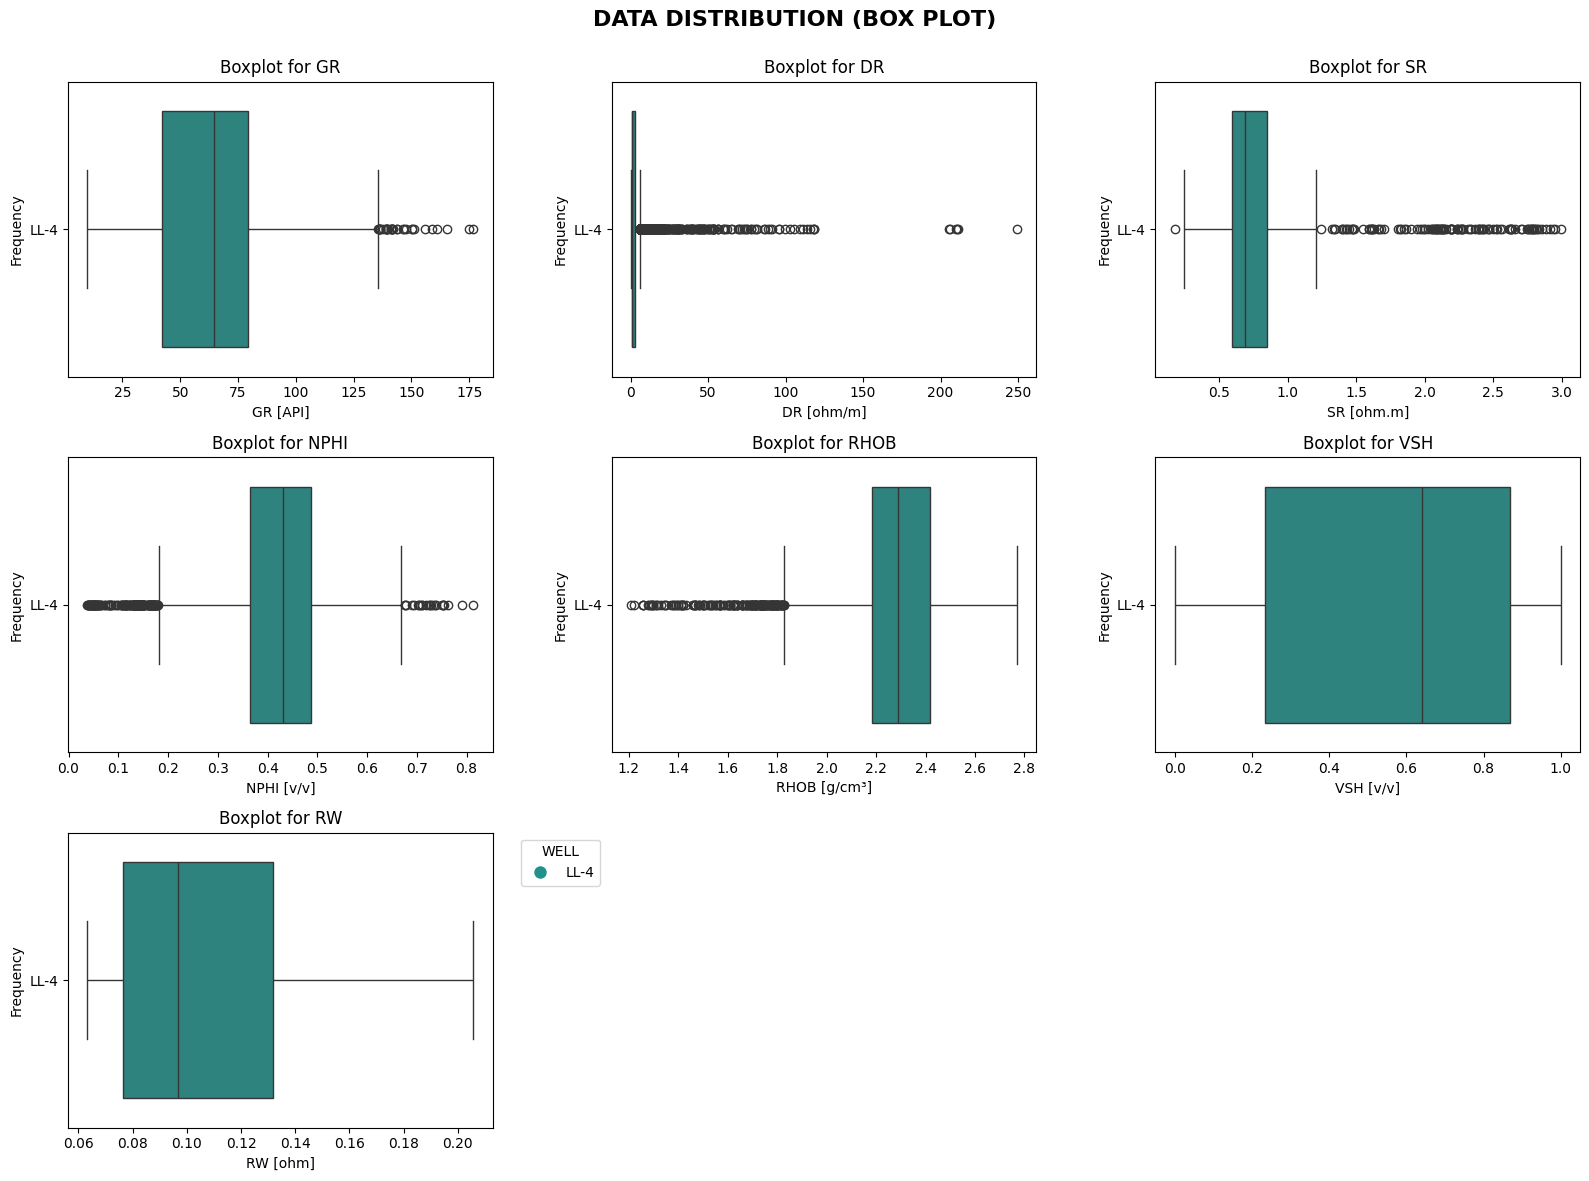

In [13]:
boxplot(data)

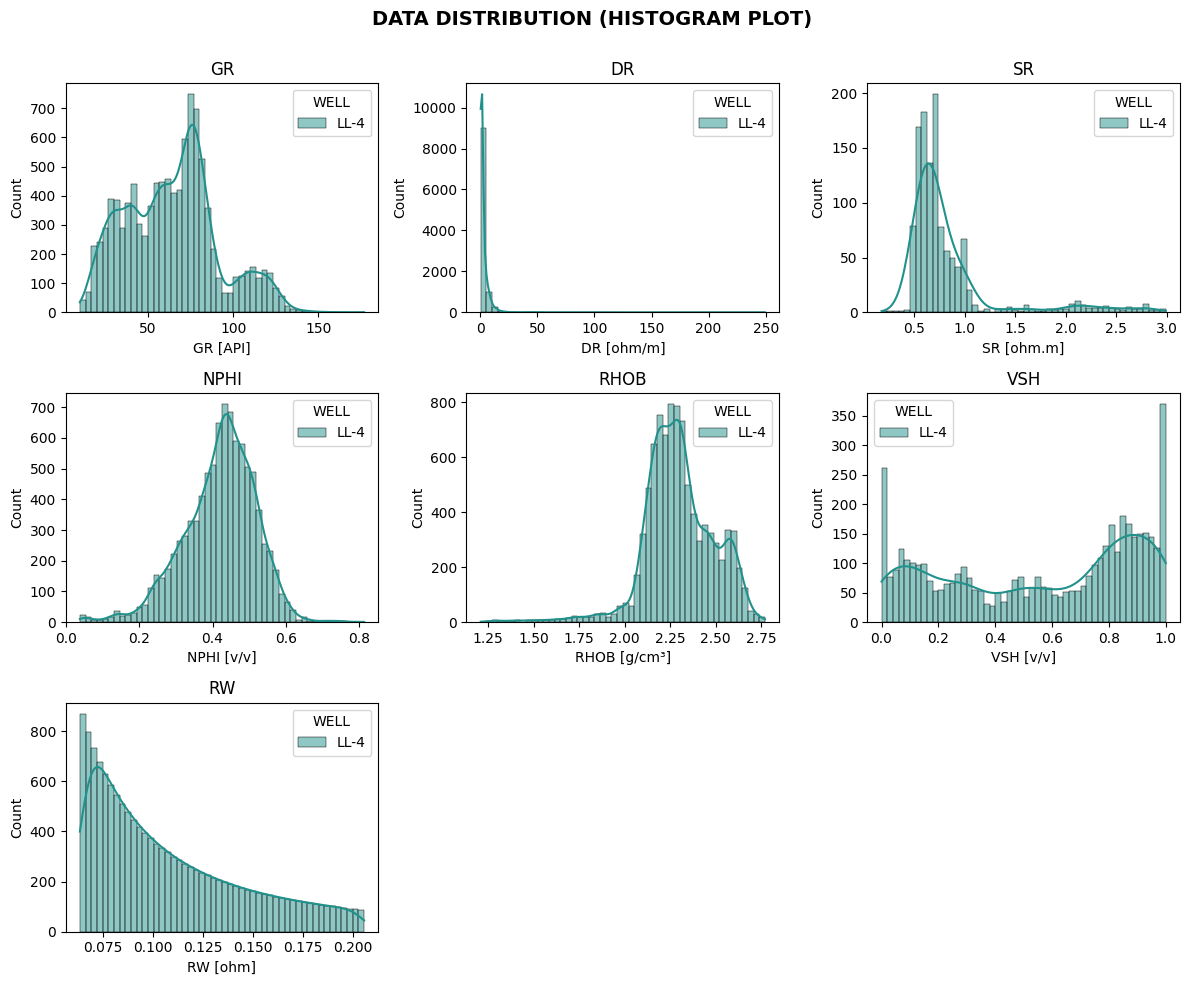

In [14]:
histplot(data)

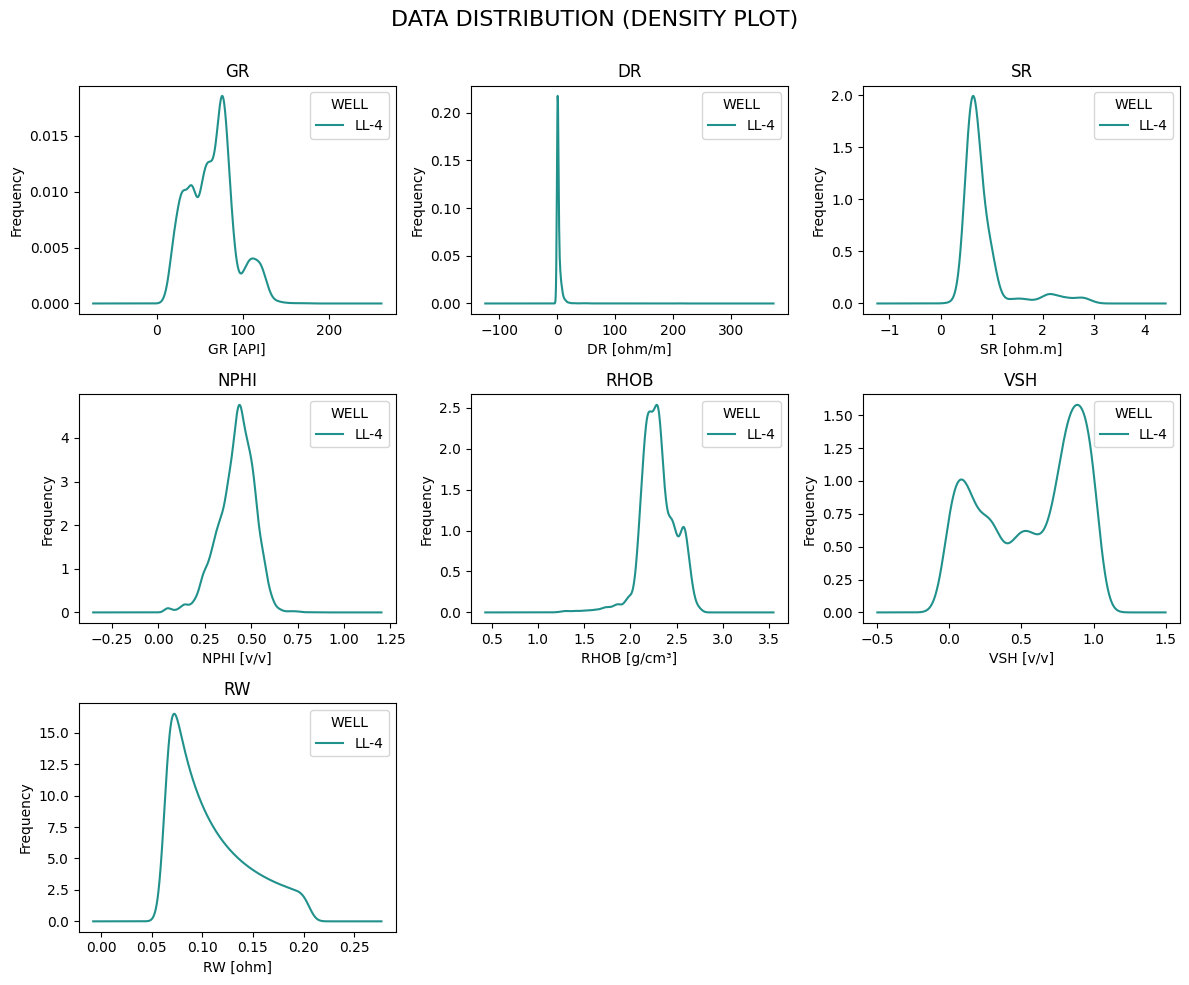

In [15]:
densityplot(data)

# **3. Outlier Handling (If Needed)**

In [20]:
def nan_handler(data, handler):
    numeric_cols = data.select_dtypes(include=['number']).columns
    if handler == "mean":
        data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
        save_name = "data_clean_mean.txt"
    elif handler == "median":
        data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
        save_name = "data_clean_median.txt"
    elif handler == "zero":
        data[numeric_cols] = data[numeric_cols].fillna(0)
        save_name = "data_clean_zeros.txt"
    else :
        save_name = "data_clean_NaN.txt"
        data[numeric_cols] = data[numeric_cols].fillna(-999.25)
    return data, save_name

In [21]:
data_copy = data.copy()
handler = "mean"
handled_data, data_name = nan_handler(data_copy, handler)

In [22]:
handled_data.describe()

DEPT            GR            MR            DR            SR  \
count  16899.000000  16899.000000  16899.000000  16899.000000  16899.000000   
mean    4224.500000     66.777814      2.524044      2.115997      1.170242   
std     2439.232717     25.089799      4.693048      4.022732      0.561850   
min        0.000000      9.253000      0.468000      0.062000      0.423600   
25%     2112.250000     55.064500      0.989000      0.924500      0.950000   
50%     4224.500000     66.777814      1.521000      1.418000      1.170242   
75%     6336.750000     77.914500      2.524044      2.115997      1.170242   
max     8449.000000    181.632000    121.531000    188.627000     14.576000   

               NPHI          RHOB   DT           VSH            RW  
count  16899.000000  16899.000000  0.0  16899.000000  16899.000000  
mean       0.374036      2.253547  NaN      0.564442      0.109372  
std        0.041961      0.055432  NaN      0.209282      0.034790  
min        0.108600      1.587000  NaN      0.000000      0.067027  
25%        0.374036      2.253547  NaN      0.564442      0.080740  
50%        0.374036      2.253547  NaN      0.564442      0.100366  
75%        0.374036      2.253547  NaN      0.564442      0.130294  
max        0.670900      2.603000  NaN      1.000000      0.207060

In [23]:
handled_data.head(100)

WELL  DEPT         GR        MR        DR        SR      NPHI      RHOB  \
0   LLB-8   0.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
1   LLB-8   0.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
2   LLB-8   1.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
3   LLB-8   1.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
4   LLB-8   2.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
..    ...   ...        ...       ...       ...       ...       ...       ...   
95  LLB-8  47.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
96  LLB-8  48.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
97  LLB-8  48.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
98  LLB-8  49.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
99  LLB-8  49.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   

    DT       VSH        RW  
0  NaN  0.564442  0.207060  
1  NaN  0.564442  0.207026  
2  NaN  0.564442  0.206993  
3  NaN  0.564442  0.206959  
4  NaN  0.564442  0.206926  
..  ..       ...       ...  
95 NaN  0.564442  0.203926  
96 NaN  0.564442  0.203893  
97 NaN  0.564442  0.203861  
98 NaN  0.564442  0.203828  
99 NaN  0.564442  0.203796  

[100 rows x 11 columns]

### ***3.1. Isolation Forest Algorithm to Detect Anomalies in Dataframe***

#### **3.1.1 Importing the isolation forest model** <br>
This code imports the IsolationForest class from scikit-learn and creates an instance of the model named model_IF. The contamination parameter is set to 0.0X, indicating that the model is expected to detect approximately X% of the data points as anomalies.

In [24]:
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest(contamination=0.01)

#### **3.1.2 Defining the list of input features for anomaly detection** <br>
his list contains the names of the columns in our dataset that are used as input features for anomaly detection.

In [25]:
#Anomaly input
columns_to_use = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
anomaly_inputs = columns_to_use

#### **3.1.3 Applying the isolation forest model to each well and incorporating anomaly scores along with labels into the original dataset.** <br>
- This loop iterates through unique values in the 'WELL' column of the dataset (data), indicating that anomaly detection is performed separately for each well.
- For each well, it selects the relevant data and fits the Isolation Forest model to the selected data using the specified input features (anomaly_inputs).
- The anomaly scores for each data point within the well are calculated using model_IF.decision_function(), and the predicted labels (1 for inliers and -1 for outliers) are obtained using model_IF.predict().
- The anomaly scores and labels for each data point within the well are stored in lists (list_anomaly_scores and list_anomaly).
These lists will be used to add the anomaly information to the original dataset.
- Finally, the code adds two new columns to the original dataset: 'anomaly_scores', which contains the anomaly scores assigned to each data point, and 'anomaly', which contains the binary labels (1 or -1) indicating whether each data point is an inlier or an outlier.

In [26]:
%%capture
#Isolation forest model fitting
def outlier_handler(data):
    list_anomaly_scores = []
    list_anomaly = []
    # if data.isna().any().any() :
    #     return data
    for i in data['WELL'].unique():
        df_WELL = data[data['WELL'] == i]
        model_IF.fit(df_WELL[anomaly_inputs])
        df_WELL['anomaly_scores'] = model_IF.decision_function(df_WELL[anomaly_inputs])
        df_WELL['anomaly'] = model_IF.predict(df_WELL[anomaly_inputs])
        for j, k in zip(list(df_WELL['anomaly_scores']), list(df_WELL['anomaly'])):
            list_anomaly_scores.append(j)
            list_anomaly.append(k)

    data['anomaly_scores'] = list_anomaly_scores
    data['anomaly'] = list_anomaly

    return data

In [27]:
handled_data = outlier_handler(handled_data)

#### **3.1.4 Anomaly plot for each anomaly inputs** <br>
This code creates a pair plot using the Seaborn library. The pair plot visualizes the relationships between pairs of variables in the "data" DataFrame. The variables specified in the "anomaly_inputs" list are used for this visualization.

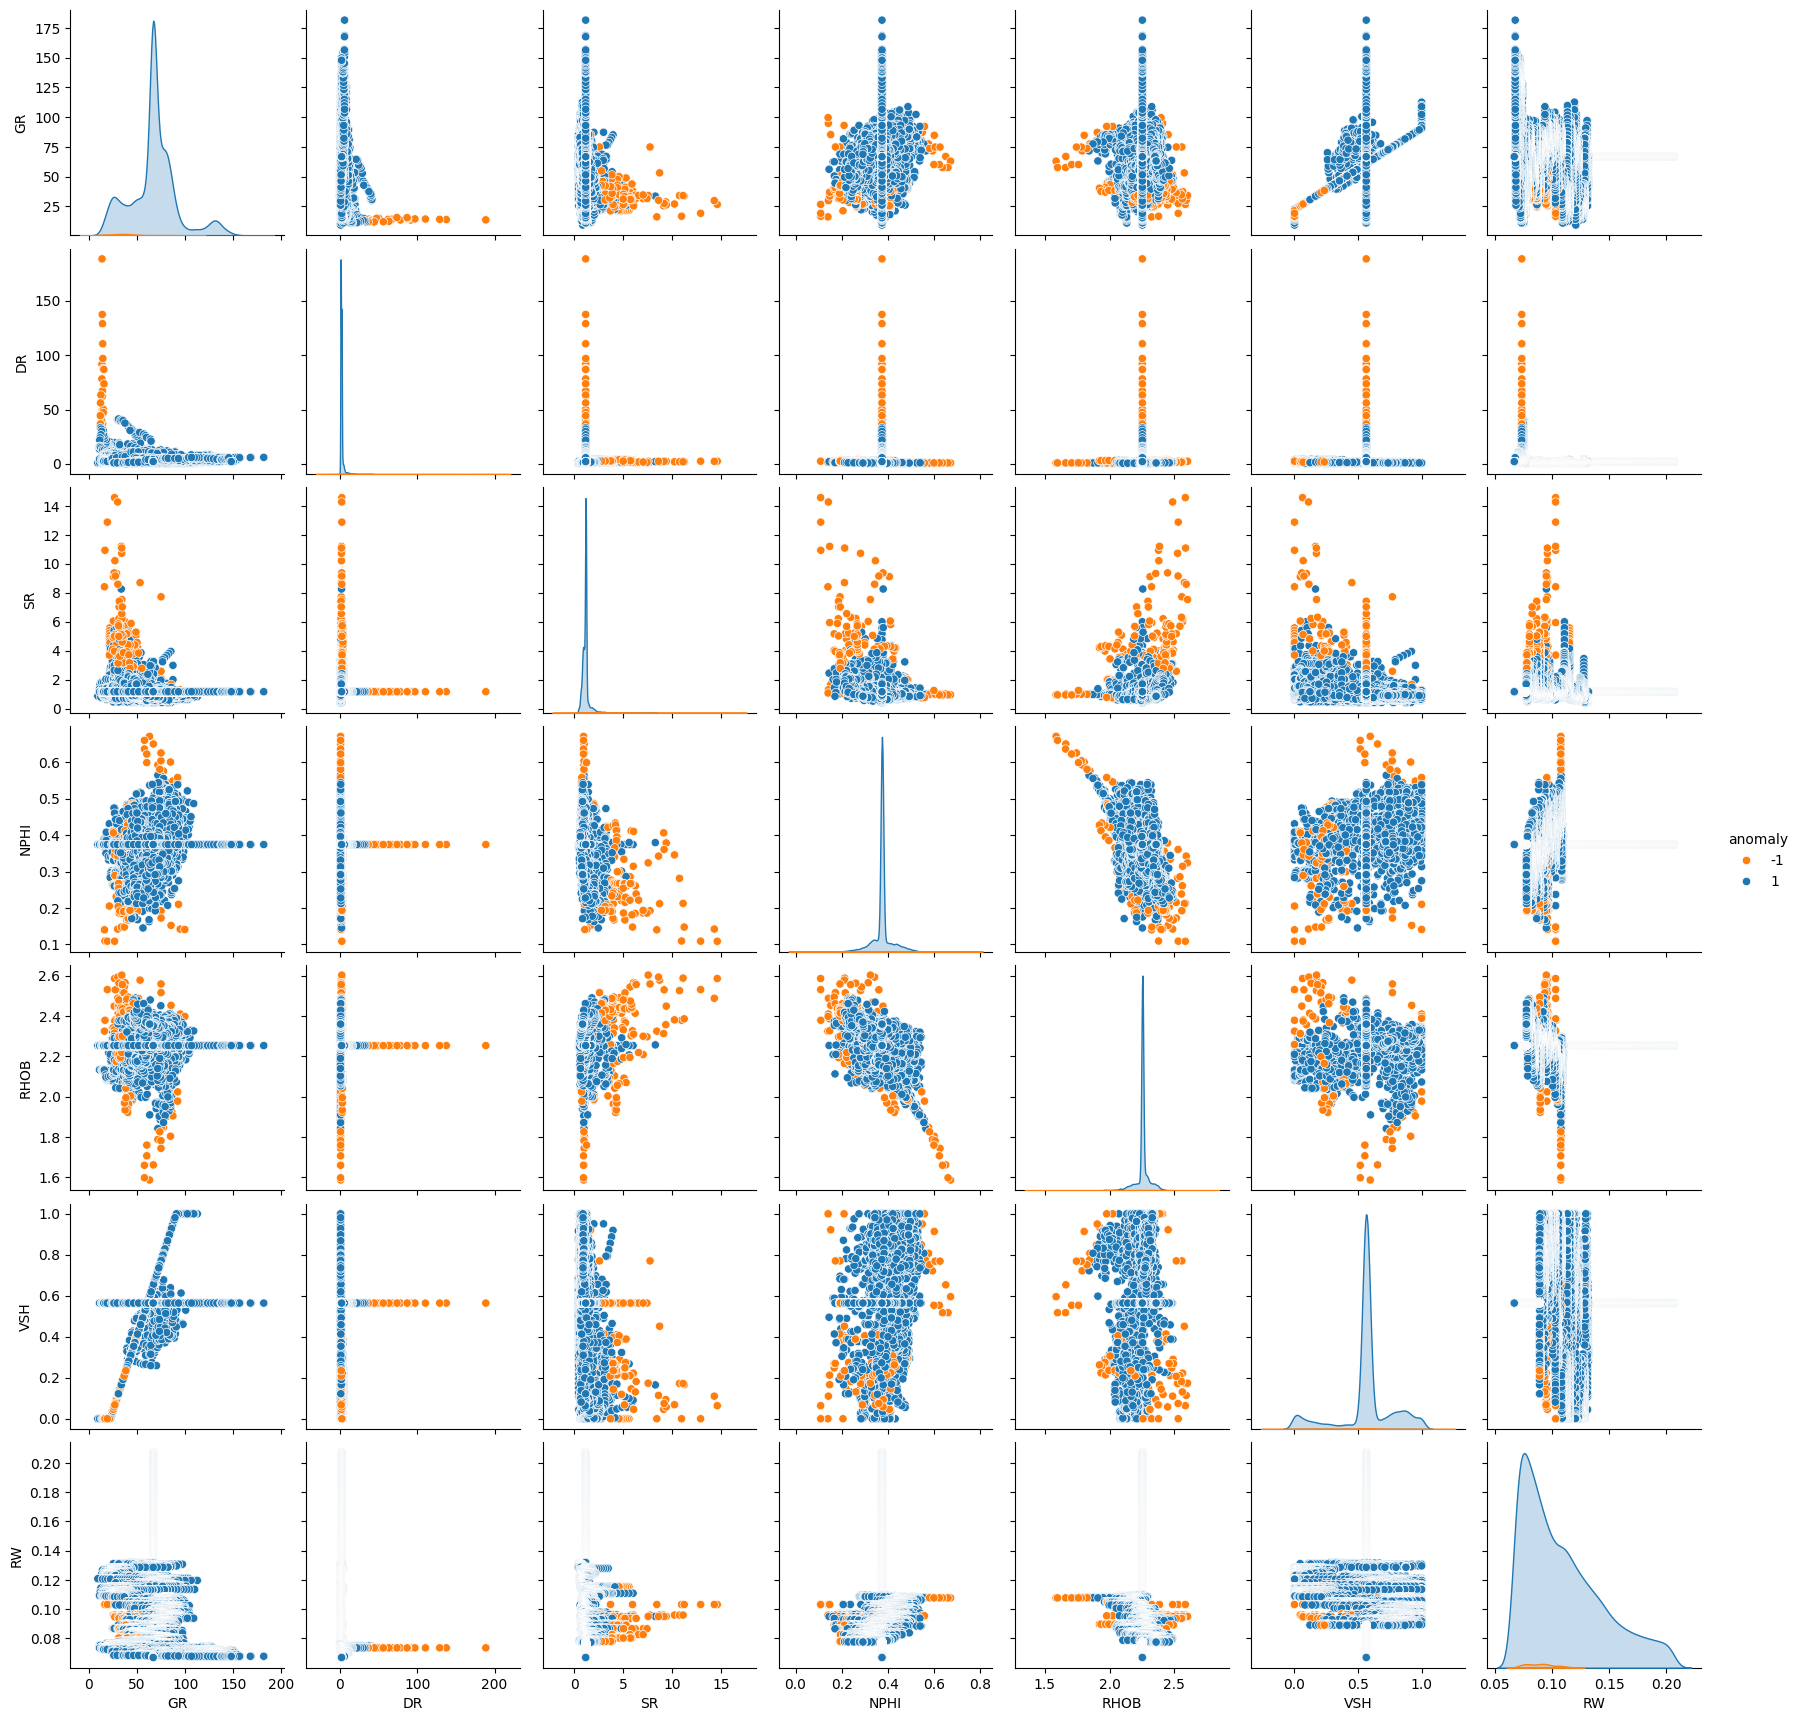

In [28]:
#Outlier plot with orange signifying outliers
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(handled_data, vars=anomaly_inputs, hue='anomaly', palette=palette)

In [29]:
#Replace rows of anomaly inputs with -999.25 for outliers
handled_data.loc[handled_data['anomaly'] == -1, anomaly_inputs] = -999.25

### ***3.2. Interpolation for anomaly in dataframe***

#### **3.2.1. Determining if a row needs interpolation or not** <br>

In [30]:
interpolate = []
for well in handled_data['WELL'].unique():
    # Get data for current well
    well_data = handled_data[handled_data['WELL'] == well]
    anomaly_list = list(well_data.anomaly)

    for i in range(len(anomaly_list)):
        current_anomaly = anomaly_list[i]

        if current_anomaly == -1:
            # Check if it's first or last point
            if i == 0 or i == len(anomaly_list) - 1:
                # Needs extrapolation
                interpolate.append(-1)
            else:
                # Check surrounding points
                prev_anomaly = anomaly_list[i-1]
                next_anomaly = anomaly_list[i+1]

                # If both surrounding points are 1, needs interpolation
                if prev_anomaly == 1 and next_anomaly == 1:
                    interpolate.append(1)
                else:
                    # No interpolation needed
                    interpolate.append(0)
        elif current_anomaly == 1:
            # No interpolation needed for normal points
            interpolate.append(0)

In [31]:
#Add interpolate column to dataframe with value of 1 defined as "interpolation needed" and -1 defined as "extrapolation needed"
handled_data['interpolate'] = interpolate

In [32]:
handled_data.describe()

DEPT            GR            MR            DR            SR  \
count  16899.000000  16899.000000  16899.000000  16899.000000  16899.000000   
mean    4224.500000     56.403798      2.524044     -8.010547     -8.863232   
std     2439.232717    108.973605      4.693048     99.660852     99.544321   
min        0.000000   -999.250000      0.468000   -999.250000   -999.250000   
25%     2112.250000     54.810000      0.989000      0.917000      0.942000   
50%     4224.500000     66.777814      1.521000      1.375000      1.170242   
75%     6336.750000     77.896000      2.524044      2.115997      1.170242   
max     8449.000000    181.632000    121.531000     41.279000      8.264000   

               NPHI          RHOB   DT           VSH            RW  \
count  16899.000000  16899.000000  0.0  16899.000000  16899.000000   
mean      -9.622233     -7.762240  NaN     -9.433106     -9.884617   
std       99.467256     99.654209  NaN     99.486474     99.440882   
min     -999.250000   -999.250000  NaN   -999.250000   -999.250000   
25%        0.374036      2.253547  NaN      0.564442      0.080265   
50%        0.374036      2.253547  NaN      0.564442      0.100153   
75%        0.374036      2.253547  NaN      0.564442      0.130294   
max        0.564100      2.490000  NaN      1.000000      0.207060   

       anomaly_scores       anomaly   interpolate  
count    16899.000000  16899.000000  16899.000000  
mean         0.182041      0.979999      0.000178  
std          0.055258      0.199009      0.013323  
min         -0.137304     -1.000000      0.000000  
25%          0.154791      1.000000      0.000000  
50%          0.188002      1.000000      0.000000  
75%          0.224512      1.000000      0.000000  
max          0.258878      1.000000      1.000000

#### **3.2.2. Interpolating -999.25 value to obtain clean data** <br>

In [33]:
param = 'DEPT'
for i in anomaly_inputs:
    for j in range(0, len(list(handled_data[i]))-1):
        if (list(handled_data[i])[j] == -999.25) & (interpolate[j] == 1):
            handled_data[i].iloc[j] = handled_data[i].iloc[j-1] + (handled_data[param].iloc[j] - handled_data[param].iloc[j-1])*(handled_data[i].iloc[j+1] - handled_data[i].iloc[j-1])/(handled_data[param].iloc[j+1] - handled_data[param].iloc[j-1])
        elif interpolate[j] == -1:
            if handled_data['WELL'].nunique() == 1:
                handled_data[i].iloc[j] = handled_data[i].iloc[j+1] + (handled_data[param].iloc[j] - handled_data[param].iloc[j+1])*(handled_data[i].iloc[j+2] - handled_data[i].iloc[j+1])/(handled_data[param].iloc[j+2] - handled_data[param].iloc[j+1])
            else:
                if handled_data['WELL'].iloc[j+1] == handled_data['WELL'].iloc[j]:
                    handled_data[i].iloc[j] = handled_data[i].iloc[j+1] + (handled_data[param].iloc[j] - handled_data[param].iloc[j+1])*(handled_data[i].iloc[j+2] - handled_data[i].iloc[j+1])/(handled_data[param].iloc[j+2] - handled_data[param].iloc[j+1])
                elif handled_data['WELL'].iloc[j-1] == handled_data['WELL'].iloc[j]:
                    handled_data[i].iloc[j] = handled_data[i].iloc[j-2] + (handled_data[param].iloc[j] - handled_data[param].iloc[j-2])*(handled_data[i].iloc[j-1] - handled_data[i].iloc[j-2])/(handled_data[param].iloc[j-1] - handled_data[param].iloc[j-2])

In [34]:
handled_data[handled_data[columns_to_use] < 0].count()

WELL                0
DEPT                0
GR                166
MR                  0
DR                166
SR                166
NPHI              166
RHOB              166
DT                  0
VSH               166
RW                166
anomaly_scores      0
anomaly             0
interpolate         0
dtype: int64

In [35]:
#Replace the remaining -999 value that is not interpolated with NaN
handled_data = handled_data.replace(-999.25, np.nan)

In [36]:
handled_data.describe()

DEPT            GR            MR            DR            SR  \
count  16899.000000  16733.000000  16899.000000  16733.000000  16733.000000   
mean    4224.500000     67.063570      2.524044      2.002547      1.141532   
std     2439.232717     24.970350      4.693048      2.522453      0.397997   
min        0.000000      9.253000      0.468000      0.062000      0.423600   
25%     2112.250000     55.961000      0.989000      0.923000      0.948000   
50%     4224.500000     66.777814      1.521000      1.399000      1.170242   
75%     6336.750000     78.063000      2.524044      2.115997      1.170242   
max     8449.000000    181.632000    121.531000     41.279000      8.264000   

               NPHI          RHOB   DT           VSH            RW  \
count  16733.000000  16733.000000  0.0  16733.000000  16733.000000   
mean       0.374577      2.253408  NaN      0.565623      0.109567   
std        0.039777      0.050920  NaN      0.208540      0.034887   
min        0.145100      1.842000  NaN      0.000000      0.067027   
25%        0.374036      2.253547  NaN      0.564442      0.080806   
50%        0.374036      2.253547  NaN      0.564442      0.100659   
75%        0.374036      2.253547  NaN      0.564442      0.130678   
max        0.564100      2.490000  NaN      1.000000      0.207060   

       anomaly_scores       anomaly   interpolate  
count    16899.000000  16899.000000  16899.000000  
mean         0.182041      0.979999      0.000178  
std          0.055258      0.199009      0.013323  
min         -0.137304     -1.000000      0.000000  
25%          0.154791      1.000000      0.000000  
50%          0.188002      1.000000      0.000000  
75%          0.224512      1.000000      0.000000  
max          0.258878      1.000000      1.000000

In [37]:
# precentage of null datas
handled_data.isnull().sum() * 100 / len(handled_data)

WELL                0.000000
DEPT                0.000000
GR                  0.982307
MR                  0.000000
DR                  0.982307
SR                  0.982307
NPHI                0.982307
RHOB                0.982307
DT                100.000000
VSH                 0.982307
RW                  0.982307
anomaly_scores      0.000000
anomaly             0.000000
interpolate         0.000000
dtype: float64

In [38]:
handled_data.columns

Index(['WELL', 'DEPT', 'GR', 'MR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT', 'VSH',
       'RW', 'anomaly_scores', 'anomaly', 'interpolate'],
      dtype='object')

In [39]:
#Drop anomaly_scores, anomaly, and interpolate from dataframe
handled_data = handled_data.drop(['anomaly_scores', 'anomaly', 'interpolate'], axis=1)

#### **3.2.3. Data Validation** <br>

In [40]:
handled_data[columns_to_use].describe()

GR            DR            SR          NPHI          RHOB  \
count  16733.000000  16733.000000  16733.000000  16733.000000  16733.000000   
mean      67.063570      2.002547      1.141532      0.374577      2.253408   
std       24.970350      2.522453      0.397997      0.039777      0.050920   
min        9.253000      0.062000      0.423600      0.145100      1.842000   
25%       55.961000      0.923000      0.948000      0.374036      2.253547   
50%       66.777814      1.399000      1.170242      0.374036      2.253547   
75%       78.063000      2.115997      1.170242      0.374036      2.253547   
max      181.632000     41.279000      8.264000      0.564100      2.490000   

                VSH            RW  
count  16733.000000  16733.000000  
mean       0.565623      0.109567  
std        0.208540      0.034887  
min        0.000000      0.067027  
25%        0.564442      0.080806  
50%        0.564442      0.100659  
75%        0.564442      0.130678  
max        1.000000      0.207060

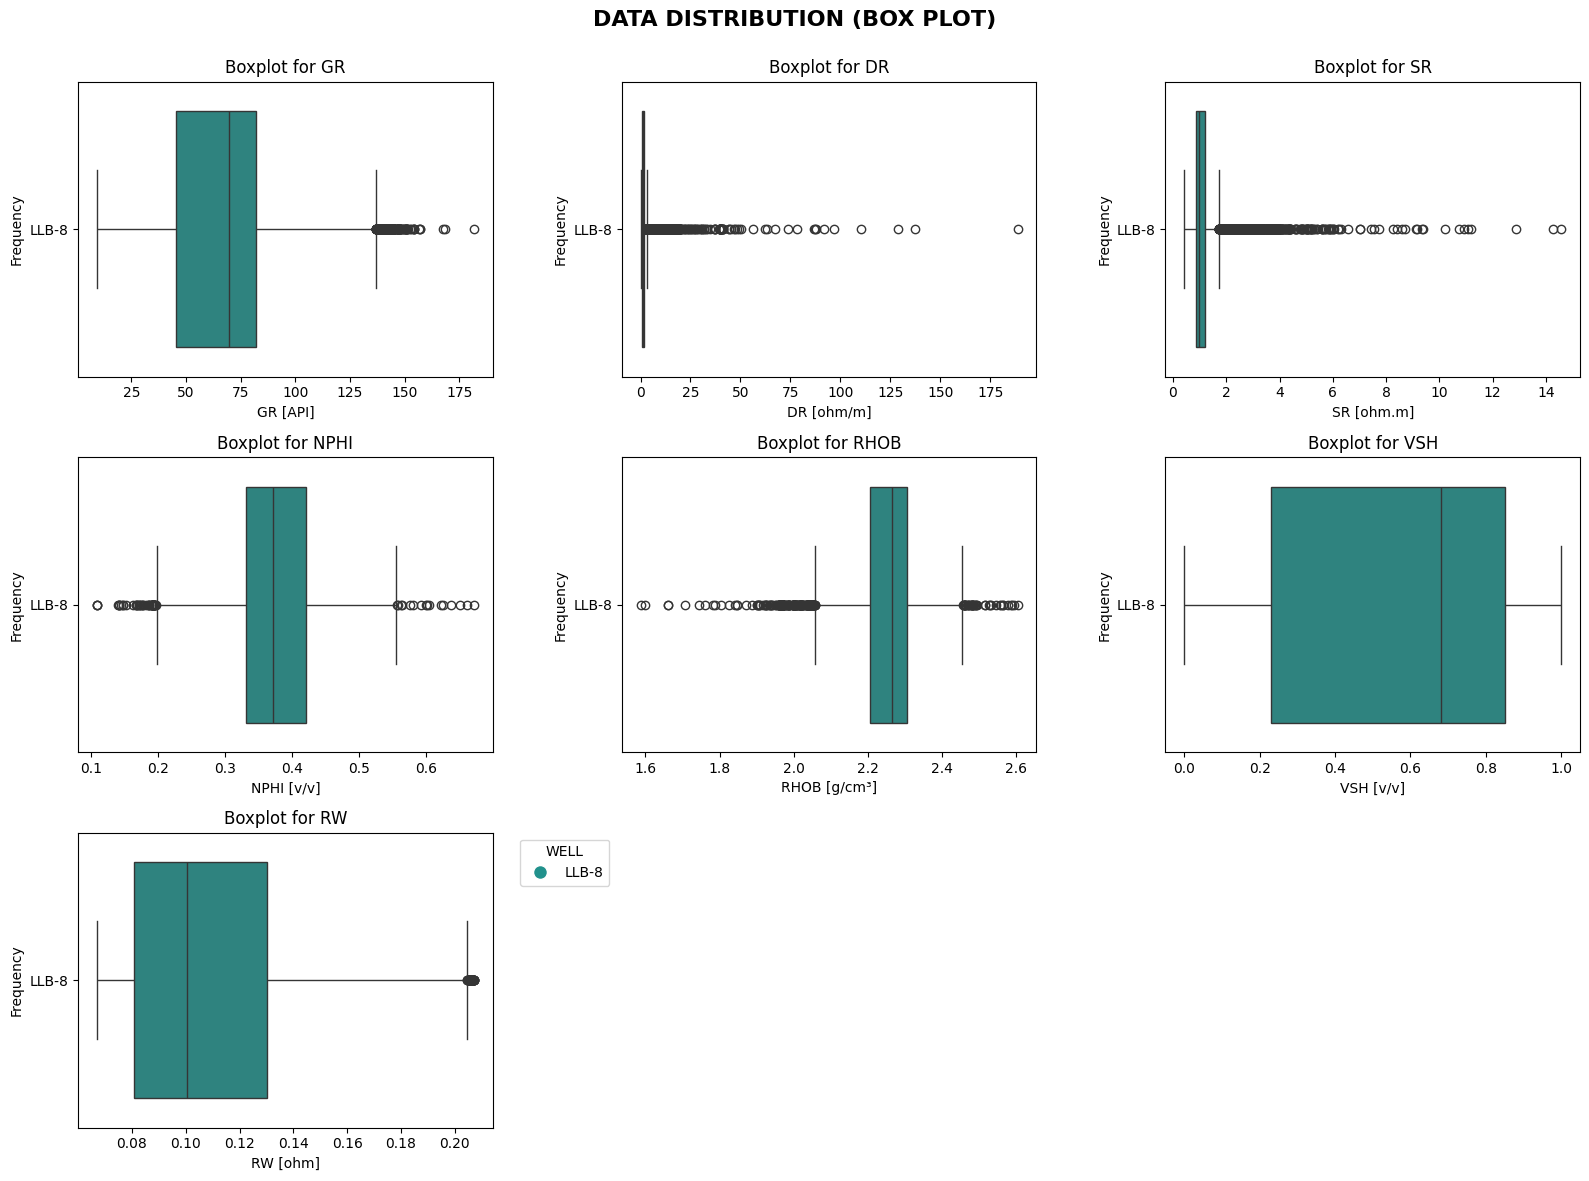

In [41]:
boxplot(data)

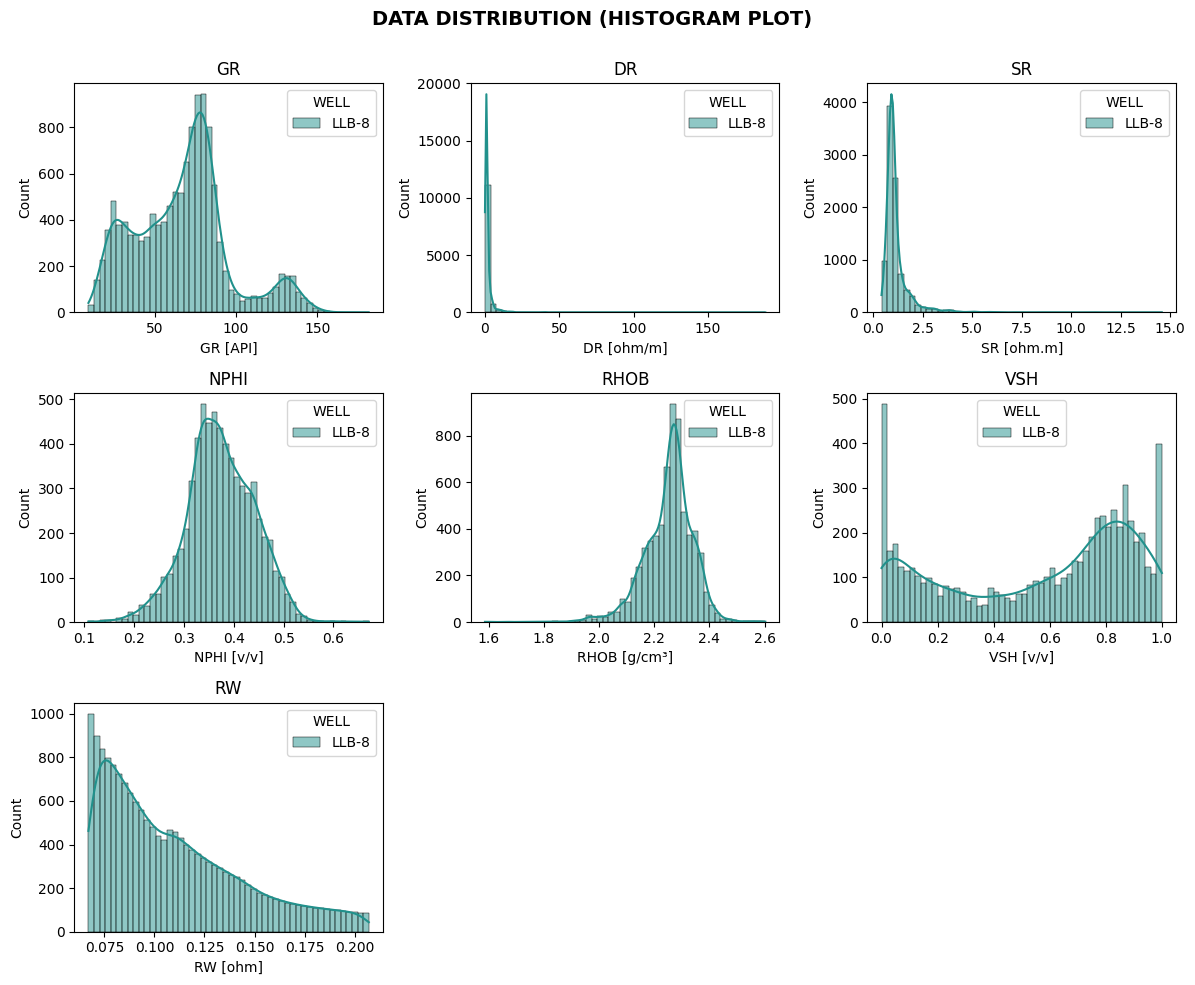

In [42]:
histplot(data)

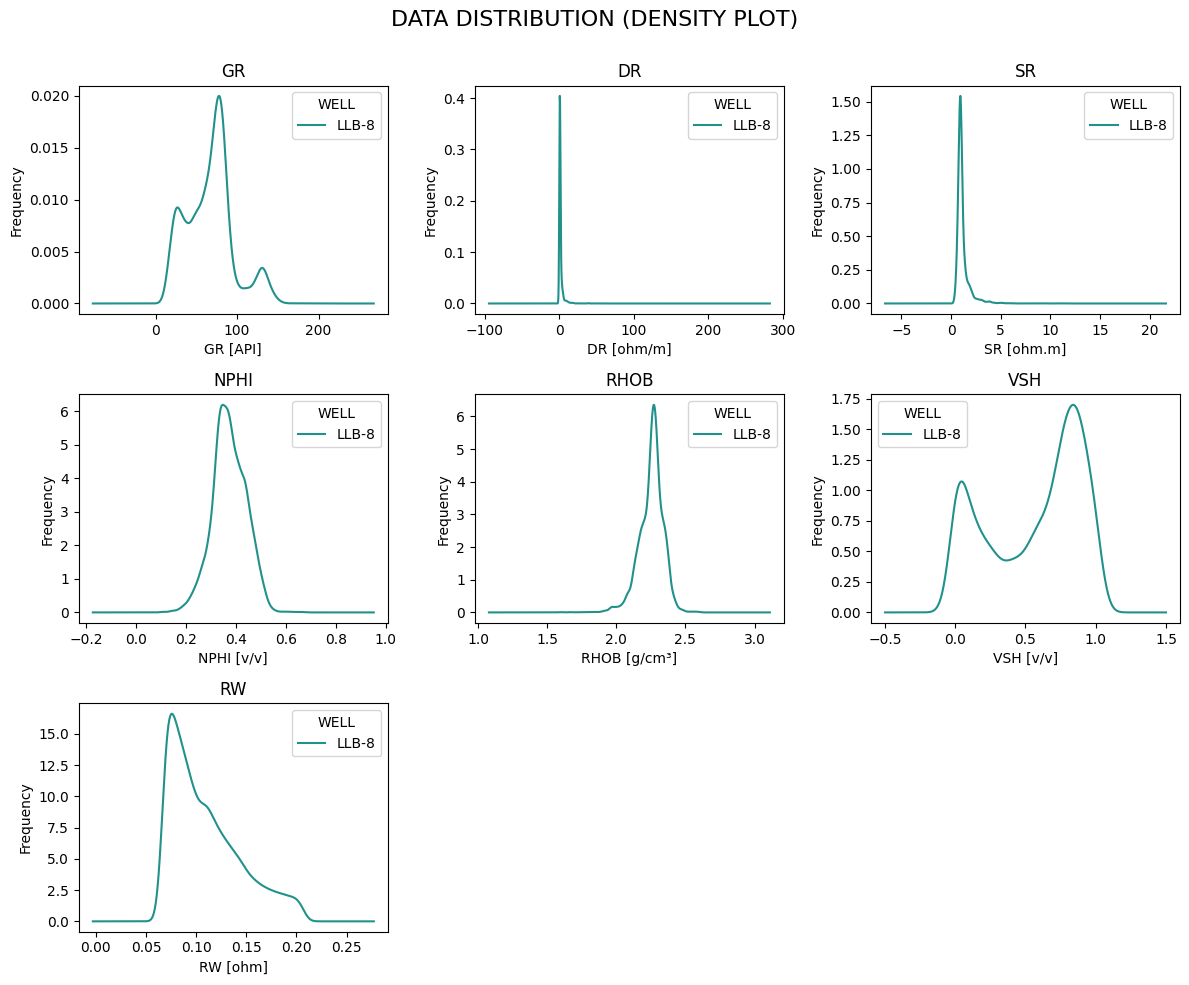

In [43]:
densityplot(data)

#### **3.2.4. Save Clean Data** <br>

In [16]:
#export dataframe to txt
# new_header = "WELL DEPT GR CALI SP DR MR SR RHOB NPHI DT WELL" DEPT 	GR 	DR 	SR 	NPHI 	RHOB 	VSH 	RW
new_header = "WELL DEPT GR MR DR SR NPHI RHOB DT VSH RW"
# data_name = "data_clean_LL4_mean.txt"
np.savetxt(data_name, handled_data, fmt='%s', delimiter='\t', header=new_header, comments='')

NameError: name 'data_name' is not defined

# **4. Data Selection, Normalization, Well Selection, and Input Core Parameter for Selected Well**

### ***4.1. Clean Data Selection***

In [48]:
data_clean = pd.read_table(data_name, delim_whitespace=True)

data_clean.head()

WELL  DEPT         GR        MR        DR        SR      NPHI      RHOB  \
0  LLB-8   0.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
1  LLB-8   0.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
2  LLB-8   1.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
3  LLB-8   1.5  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   
4  LLB-8   2.0  66.777814  2.524044  2.115997  1.170242  0.374036  2.253547   

   DT       VSH        RW  
0 NaN  0.564442  0.207060  
1 NaN  0.564442  0.207026  
2 NaN  0.564442  0.206993  
3 NaN  0.564442  0.206959  
4 NaN  0.564442  0.206926

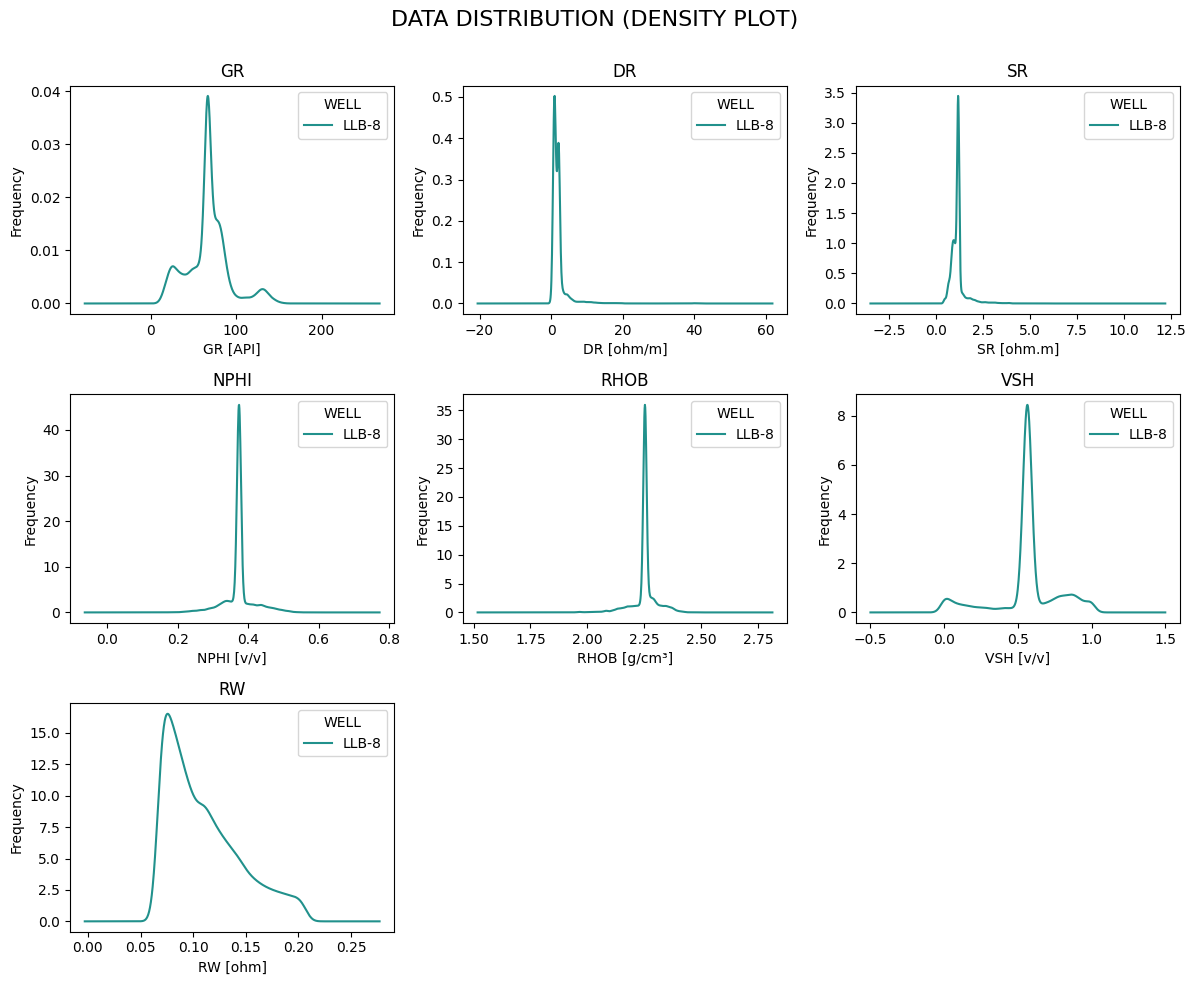

In [49]:
densityplot(data_clean)

### ***4.2. Data Normalization***

In [50]:
def normalise(curve, ref_low, ref_high, well_low, well_high):
    return ref_low + ((ref_high - ref_low) * ((curve - well_low) / (well_high - well_low)))

def normalise_log(df, key_well, log):
    for i in log:
        df['05_PERC'] = df['WELL'].map(df.groupby('WELL')[i].quantile(0.05))
        df['95_PERC'] = df['WELL'].map(df.groupby('WELL')[i].quantile(0.95))
        key_well_low = df.groupby('WELL')[i].quantile(0.05)[key_well]
        key_well_high = df.groupby('WELL')[i].quantile(0.95)[key_well]
        list_norm = df.apply(lambda x: normalise(x[i], key_well_low, key_well_high, x['05_PERC'], x['95_PERC']), axis=1)
        df = df.drop([i, '05_PERC', '95_PERC'], axis=1)
        df[i] = list_norm

    return df

In [51]:
data_clean_backup = data_clean.copy()

In [52]:
log = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
key_well = well_name

data__clean_normalized = normalise_log(data_clean, key_well, log)

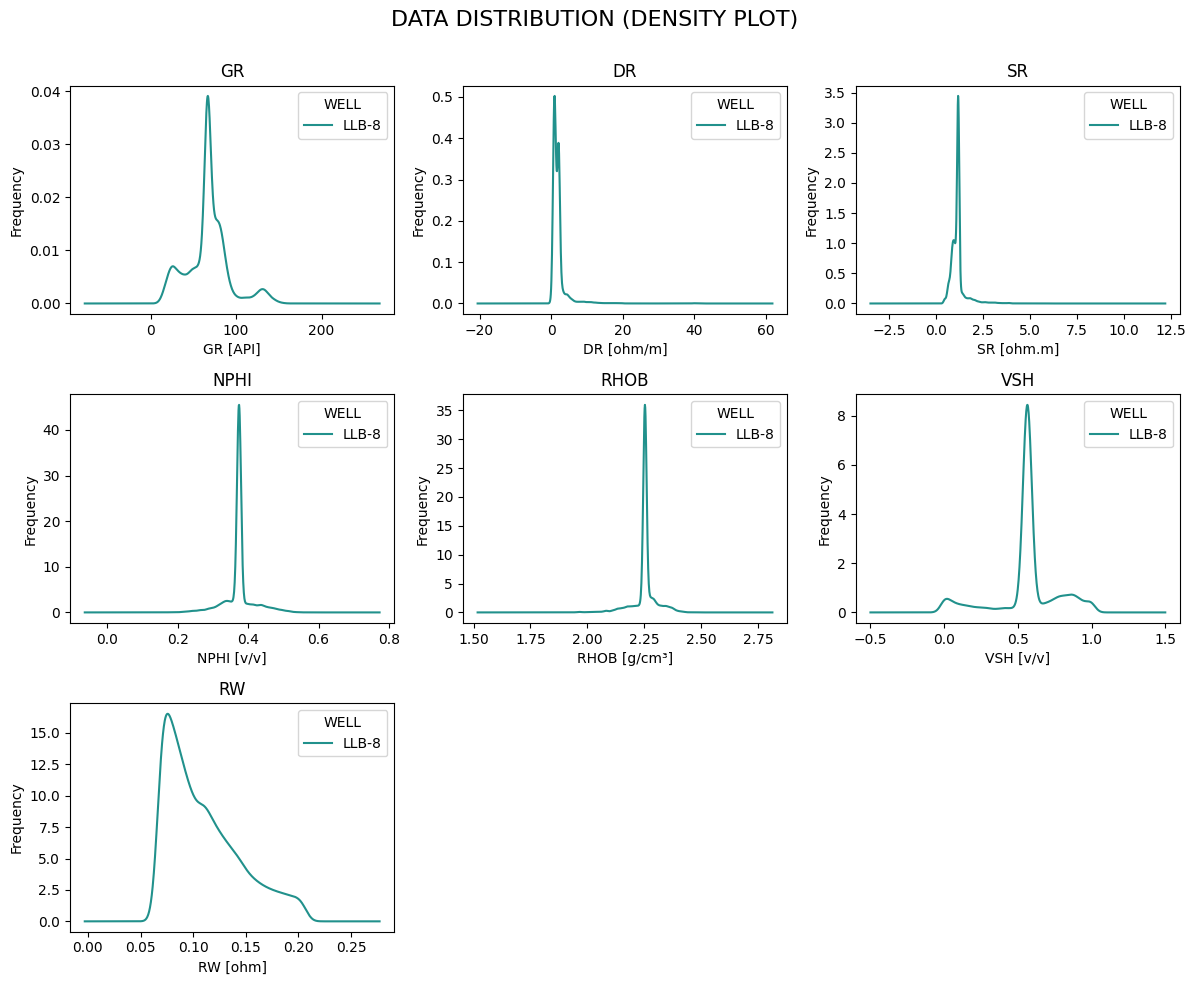

In [53]:
densityplot(data__clean_normalized)

### ***4.3. Select the Well***

In [17]:
# Create a copy of the data for selected well (Whicher-2)
selected_data = data[data['WELL'] == well_name].copy()

### ***4.4. Input Core Data (Porosity and Permeability) for Selected Well***

In [18]:
selected_data["core_por"] = ""
selected_data["core_perm"] = ""

# Define the number of random samples you want
num_samples = 100  # You can change this to the desired number of samples

# Generate random values for 'DEPT' between 900 and 4300
dept_values = np.random.uniform(0, 8400, num_samples)

# Generate random values for 'core_por' between 0 and 1 and "core_perm" between 0 and 1000
core_por_values = np.random.uniform(0, 1, num_samples)
core_perm_values = np.random.uniform(0, 1000, num_samples)

# Create a dictionary with the generated values. This for example only
dict_core = {
    'DEPT': dept_values.tolist(),  # Convert to a list
    'core_por': core_por_values.tolist(),  # Convert to a list
    "core_perm" : core_perm_values.tolist() # Convert to a list
}

# must inpute manually based on core data
"""dict_core = {'DEPT':[4220,4240,4260],
        'DEPT':[4220,4240,4260],
        'core_por':[0.148, 0.287,0.103],
        'core_perm':[0.0001,0.0001,0.0001]
       } """


core_selected_data = pd.DataFrame(dict_core)
selected_data.set_index("DEPT");

## **5. DISPLAY DATA LOGS**
Display is done by describing a function named combo_plot<br>
combo_plot displays three traject, namely:<br>
- Traject 1: GR, SP, CALI
- Traject 2: Resistivities (ILD, ILM, ILS, LL8, SFL, or other)
- Traject 3: Density (RHOB), Sonic(DT) and Neutronic (NPHI)

In [19]:
# Create the figure and subplots
def combo_plot(data, top_depth, bottom_depth, figure_height,subplotadjust,SP_min,SP_max,CALI_min,CALI_max,GR_min,GR_max,DR_min,DR_max,MR_min,MR_max,SR_min,SR_max,RHOB_min,RHOB_max,NPHI_min,NPHI_max,DT_min,DT_max,smoothing_traject1,smoothing_traject2,smoothing_traject3,major_ticks_interval,minor_ticks_interval):

    logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,figure_height), sharey=True) #pembuatan format 1 baris 3 kolom, width 12 height 10, dan sumbu y yang sama (sharey)
    fig.suptitle(f"LOG CURVE".upper(), fontsize=22)
    fig.subplots_adjust(top=subplotadjust,wspace=0.1)


    #General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(major_ticks_interval))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(minor_ticks_interval))
        axes.get_xaxis().set_visible(False)

    #Smoothing the graph
    if (smoothing_traject1 == "yes"):
        logs.GR.dropna(inplace=True)
        logs.CALI.dropna(inplace=True)
        logs.SP.dropna(inplace=True)

        logs.GR = logs[["GR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.CALI = logs[["CALI"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.SP = logs[["SP"]].apply(savgol_filter,  window_length=5, polyorder=3)

    if (smoothing_traject2 == "yes"):
        logs.DR.dropna(inplace=True)
        logs.MR.dropna(inplace=True)
        logs.SR.dropna(inplace=True)

        logs.DR = logs[["DR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.MR = logs[["MR"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.SR = logs[["SR"]].apply(savgol_filter,  window_length=5, polyorder=3)

    if (smoothing_traject3 == "yes"):
        logs.RHOB.dropna(inplace=True)
        logs.NPHI.dropna(inplace=True)
        logs.DT.dropna(inplace=True)

        logs.RHOB = logs[["RHOB"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.NPHI = logs[["NPHI"]].apply(savgol_filter,  window_length=5, polyorder=3)
        logs.DT = logs[["DT"]].apply(savgol_filter,  window_length=5, polyorder=3)

#First Trajectory: GR, CALI, SP
    #Gamma Ray lot
    if ("GR" in data.columns and (GR_min!=0 or GR_max!=0)):
        ax01=ax[0].twiny()
        if GR_min != "auto" and GR_max != "auto":
            ax01.set_xlim(GR_min,GR_max)
        ax01.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        ax01.yaxis.set_major_locator(ticker.MultipleLocator(50))
        ax01.plot(logs.GR, logs.DEPT, label='GR[api]', color='green')
        ax01.spines['top'].set_position(('outward',80))
        ax01.set_xlabel('GR[api]',color='green')
        ax01.tick_params(axis='x', colors='green')

    #Caliper Plot
    if ("CALI" in data.columns and (CALI_min!=0 or CALI_max!=0)):
        ax02=ax[0].twiny()
        if CALI_min != "auto" and CALI_max != "auto":
            ax02.set_xlim(CALI_min,CALI_max)
        ax02.plot(logs.CALI, logs.DEPT, '--', label='CALN[in]', color='black')
        ax02.spines['top'].set_position(('outward',40))
        ax02.set_xlabel('CALI[in]',color='black')
        ax02.tick_params(axis='x', colors='black')
        #ax02.axvline(x=7.9, linewidth=2, color='black') #digunakan untuk plot bit size ukuran 7.9 in

    #Spontaneous Potential Plot
    if ("SP" in data.columns and (SP_min!=0 or SP_max!=0)):
        ax03=ax[0].twiny()
        if SP_min != "auto" and SP_max != "auto":
            ax03.set_xlim(SP_min,SP_max)
        ax03.spines['top'].set_position(('outward',0))
        ax03.set_xlabel("SP [mV]")
        ax03.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
        ax03.set_xlabel('SP[mV]',color='blue')
        ax03.tick_params(axis='x', colors='blue')
        ax03.grid(True)


#Second Trajectory: DR, MR, SR
    #Deep Resistivity Plot
    if ("DR" in data.columns and (DR_min!=0 or DR_max!=0)):
        ax11=ax[1].twiny()
        if DR_min != "auto" and DR_max != "auto":
            ax11.set_xlim(DR_min,DR_max)
        ax11.set_xscale('log')
        ax11.grid(visible=None, which='both')
        ax11.spines['top'].set_position(('outward',80))
        ax11.set_xlabel('Deep Resistivity [ohm.m]', color='red')
        ax11.plot(logs.DR, logs.DEPT, label='DR [ohm.m]', color='red')
        ax11.tick_params(axis='x', colors='red')

    #Medium Resistivity Plot
    if("MR" in data.columns and (MR_min!=0 or MR_max!=0)):
        ax12=ax[1].twiny()
        if MR_min != "auto" and MR_max != "auto":
            ax12.set_xlim(MR_min,MR_max)
        ax12.set_xscale('log')
        ax12.grid(visible=None, which='both')
        ax12.spines['top'].set_position(('outward',40))
        ax12.set_xlabel('Medium Resistivity [ohm.m]', color='purple')
        ax12.plot(logs.MR, logs.DEPT, label='MR [ohm.m]', color='purple')
        ax12.tick_params(axis='x', colors='purple')

    #Shallow Resistivity Plot
    if("SR" in data.columns and (SR_min!=0 or SR_max!=0)):
        ax13=ax[1].twiny()
        if SR_min != "auto" and SR_max != "auto":
            ax13.set_xlim(SR_min,SR_max)
        ax13.set_xscale('log')
        ax13.grid(visible=None, which='both')
        ax13.spines['top'].set_position(('outward',0))
        ax13.set_xlabel('Shallow Resistivity [ohm.m]',color='black')
        ax13.plot(logs.SR, logs.DEPT, '--',label='SR[ohm.m]', color='black')
        ax13.tick_params(axis='x', colors='black')


#Third Trajectory: RHOB, NPHI, DT
    #Density Plot
    if ("RHOB" in data.columns and (RHOB_min!=0 or RHOB_max!=0)):
        ax21=ax[2].twiny()
        if RHOB_min != "auto" and RHOB_max != "auto":
            ax21.set_xlim(RHOB_min,RHOB_max)
        ax21.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red')
        ax21.spines['top'].set_position(('outward',80))
        ax21.set_xlabel('RHOB[g/cc]',color='red')
        ax21.tick_params(axis='x', colors='red')

    #Neutron Porosity Plot
    if ("NPHI" in data.columns and (NPHI_min!=0 or NPHI_max!=0)):
        ax22=ax[2].twiny()
        if NPHI_min != "auto" and NPHI_max != "auto":
            ax22.set_xlim(NPHI_min,NPHI_max)
        ax22.invert_xaxis()
        ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green')
        ax22.spines['top'].set_position(('outward',40))
        ax22.set_xlabel('NPHI[%]', color='green')
        ax22.tick_params(axis='x', colors='green')

    #Sonic Plot
    if ("DT" in data.columns and (DT_min!=0 or DT_max!=0)):
        ax23=ax[2].twiny()
        ax23.grid(True, which='both')
        if DT_min != "auto" and DT_max != "auto":
            ax23.set_xlim(DT_min,DT_max)
        ax23.spines['top'].set_position(('outward',0))
        ax23.set_xlabel('DT[us/ft]')
        ax23.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
        ax23.set_xlabel('DT[us/ft]', color='blue')
        ax23.tick_params(axis='x', colors='blue')

In [27]:
def custom_interpretation_plot(logs, depth_start, depth_end, *custom_logs, units):
    num_tracks = len(custom_logs)
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(15, 20), sharey=True)
    fig.suptitle("Custom Interpretation Plot", fontsize=22)

    # Calculate top value with less free space based on the number of tracks
    top_value = 1 - 0.015 * num_tracks

    # Adjust top parameter to leave less free space at the top
    fig.subplots_adjust(top=top_value, wspace=0.2)

    units = units  # in list

    depth_range = depth_end - depth_start

    # Dynamically adjust tick intervals based on the depth range
    if depth_range > 5000:
        major_tick_interval = 1000
        minor_tick_interval = 100
    elif depth_range > 1000:
        major_tick_interval = 500
        minor_tick_interval = 50
    else:
        major_tick_interval = 100
        minor_tick_interval = 10

    # General setting for all axes
    for axes in ax:
        axes.set_ylim(depth_start, depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(major_tick_interval))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(minor_tick_interval))
        axes.get_xaxis().set_visible(False)

    # Customizing each track with unit and color
    for i, log_name in enumerate(custom_logs):
        current_ax = ax[i].twiny()
        current_ax.plot(logs[log_name], logs.DEPT, label=f'{log_name} [{units[i]}]', color='C'+str(i))
        if log_name == "DR" or log_name == "MR" or log_name == "SR":
            current_ax.set_xscale('log')
        current_ax.set_xlabel(f'{log_name} [{units[i]}]', color='C'+str(i))
        current_ax.tick_params(axis='x', colors='C'+str(i))
        current_ax.spines['top'].set_position(('outward',0))
        current_ax.legend(loc='lower right', facecolor='white', framealpha=1, fontsize=7)
    plt.show()


In [20]:
selected_data.describe()

DEPT            GR          CALI            MR            DR  \
count  13981.000000  10390.000000  10394.000000  10374.000000  10440.000000   
mean    3495.000000     63.907625     12.115885      2.312847      3.093636   
std     2018.055696     27.017865      3.027074      3.298621      8.397807   
min        0.000000      9.900000      0.000000      0.200600      0.330000   
25%     1747.500000     42.062500      9.460000      0.717725      0.802975   
50%     3495.000000     64.720000     12.340000      0.932550      1.040000   
75%     5242.500000     79.400000     12.740000      2.450075      2.852450   
max     6990.000000    176.800000     22.270000     46.344700    249.379000   

                SR         NPHI         RHOB           DT          VSH  \
count  1210.000000  9184.000000  9314.000000  9615.000000  4679.000000   
mean      0.835083     0.420528     2.296849   107.581031     0.561747   
std       0.480027     0.097965     0.191633    24.303341     0.340048   
min       0.174200     0.038000     1.210000     0.000000     0.000000   
25%       0.591600     0.363900     2.182900    89.500000     0.233600   
50%       0.688700     0.431500     2.287200   108.550000     0.641300   
75%       0.851100     0.487025     2.420000   122.100000     0.868800   
max       2.992300     0.813700     2.770000   191.061000     1.000000   

                 RW  
count  13981.000000  
mean       0.107826  
std        0.037525  
min        0.063355  
25%        0.076609  
50%        0.096876  
75%        0.131724  
max        0.205728

In [21]:
selected_data.head(20)

WELL  DEPT  GR  CALI  MR  DR  SR  NPHI  RHOB  DT  VSH        RW core_por  \
0   LL-4   0.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205728            
1   LL-4   0.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205695            
2   LL-4   1.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205662            
3   LL-4   1.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205629            
4   LL-4   2.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205596            
5   LL-4   2.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205563            
6   LL-4   3.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205530            
7   LL-4   3.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205497            
8   LL-4   4.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205464            
9   LL-4   4.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205431            
10  LL-4   5.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205398            
11  LL-4   5.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205365            
12  LL-4   6.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205332            
13  LL-4   6.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205299            
14  LL-4   7.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205266            
15  LL-4   7.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205234            
16  LL-4   8.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205201            
17  LL-4   8.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205168            
18  LL-4   9.0 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205135            
19  LL-4   9.5 NaN   NaN NaN NaN NaN   NaN   NaN NaN  NaN  0.205102            

   core_perm  
0             
1             
2             
3             
4             
5             
6             
7             
8             
9             
10            
11            
12            
13            
14            
15            
16            
17            
18            
19

### **5.1. Full depth display**

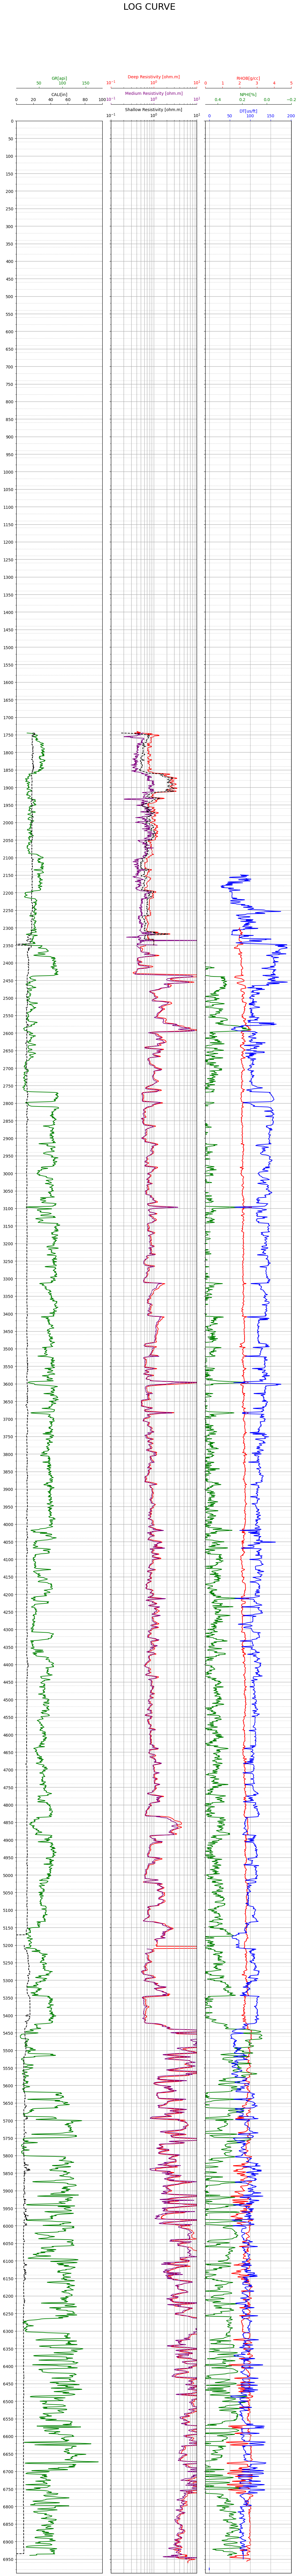

In [24]:
# DISPLAYS LOG DATA FROM THE END TO THE BOTTOM (MENTAHAN)
SP_min = "auto" #lowersp limit sp
SP_max = "auto" #sp upper limit
CALI_min = 0 #CALI lower limit
CALI_max = 100 #CALI upper limit
GR_min = "auto" #lower limit GR
GR_max = "auto" #upper limit of GR
DR_min = 0.1 #DR lower limit
DR_max = 10 #DR upper limit
MR_min = 0.1 #MR lower bound
MR_max = 10 #MR upper limit
SR_min = 0.1 #lower SR limit
SR_max = 10 #SR upper limit
RHOB_min = 0 #lower limit of RHOB
RHOB_max = 5 #upper limit of RHOB
NPHI_min = -0.2 #NPHI lower limit
NPHI_max = 0.5 #NPHI upper limit
DT_min = "auto" #lowerlimit DT
DT_max = "auto" #upper limit of DT
smoothing_traject1 = "no" #default "no"
smoothing_traject2 = "no" #default "no"
smoothing_traject3 = "no" #default "no"

combo_plot(
    selected_data,
    selected_data.DEPT.min(),
    selected_data.DEPT.max(),
    100,               #figure height in inch
    0.94,              #figure position
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    DT_min,
    DT_max,
    smoothing_traject1,
    smoothing_traject2,
    smoothing_traject3,
    100,
    20
    )

### **5.2. Selected Depth Display**

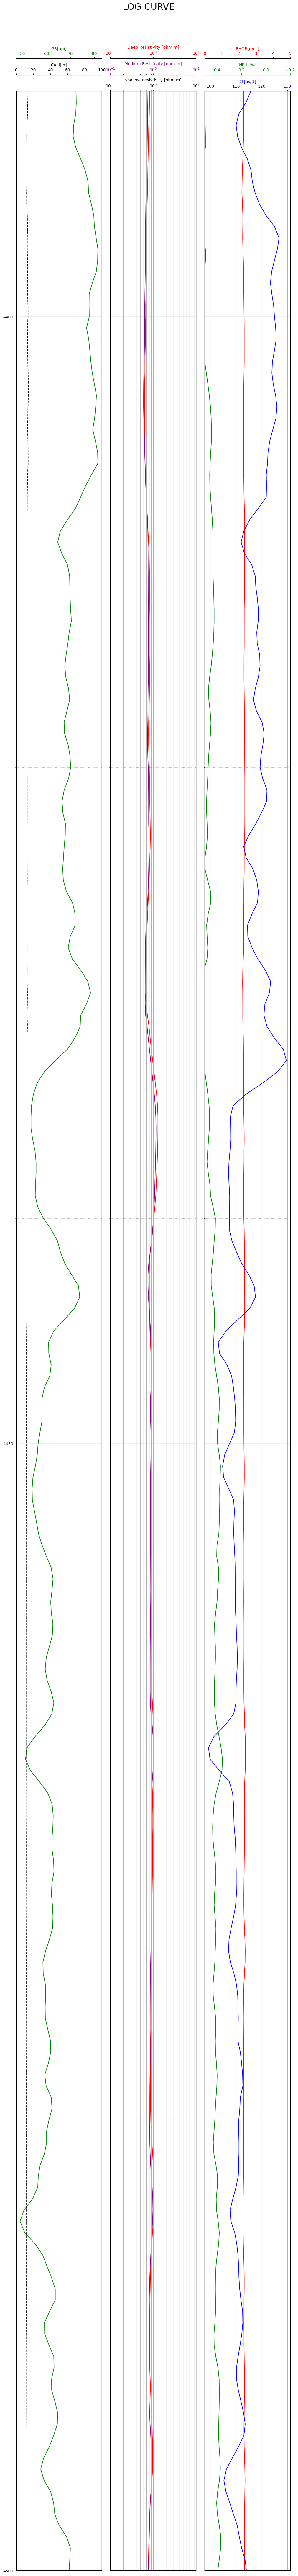

In [25]:
#MENAMPILKAN DATA LOG DARI UJUNG ATAS SAMPAI BAWAH YANG DIINGINKAN

depth_start = 4390
depth_end = 4500

combo_plot(
    selected_data,
    depth_start,
    depth_end,
    100,               #figure height in inch
    0.95,             #figure position
    SP_min,
    SP_max,
    CALI_min,
    CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    DT_min,
    DT_max,
    smoothing_traject1,
    smoothing_traject2,
    smoothing_traject3,
    100,
    20
    )

### **5.3. Custom Variable Display**

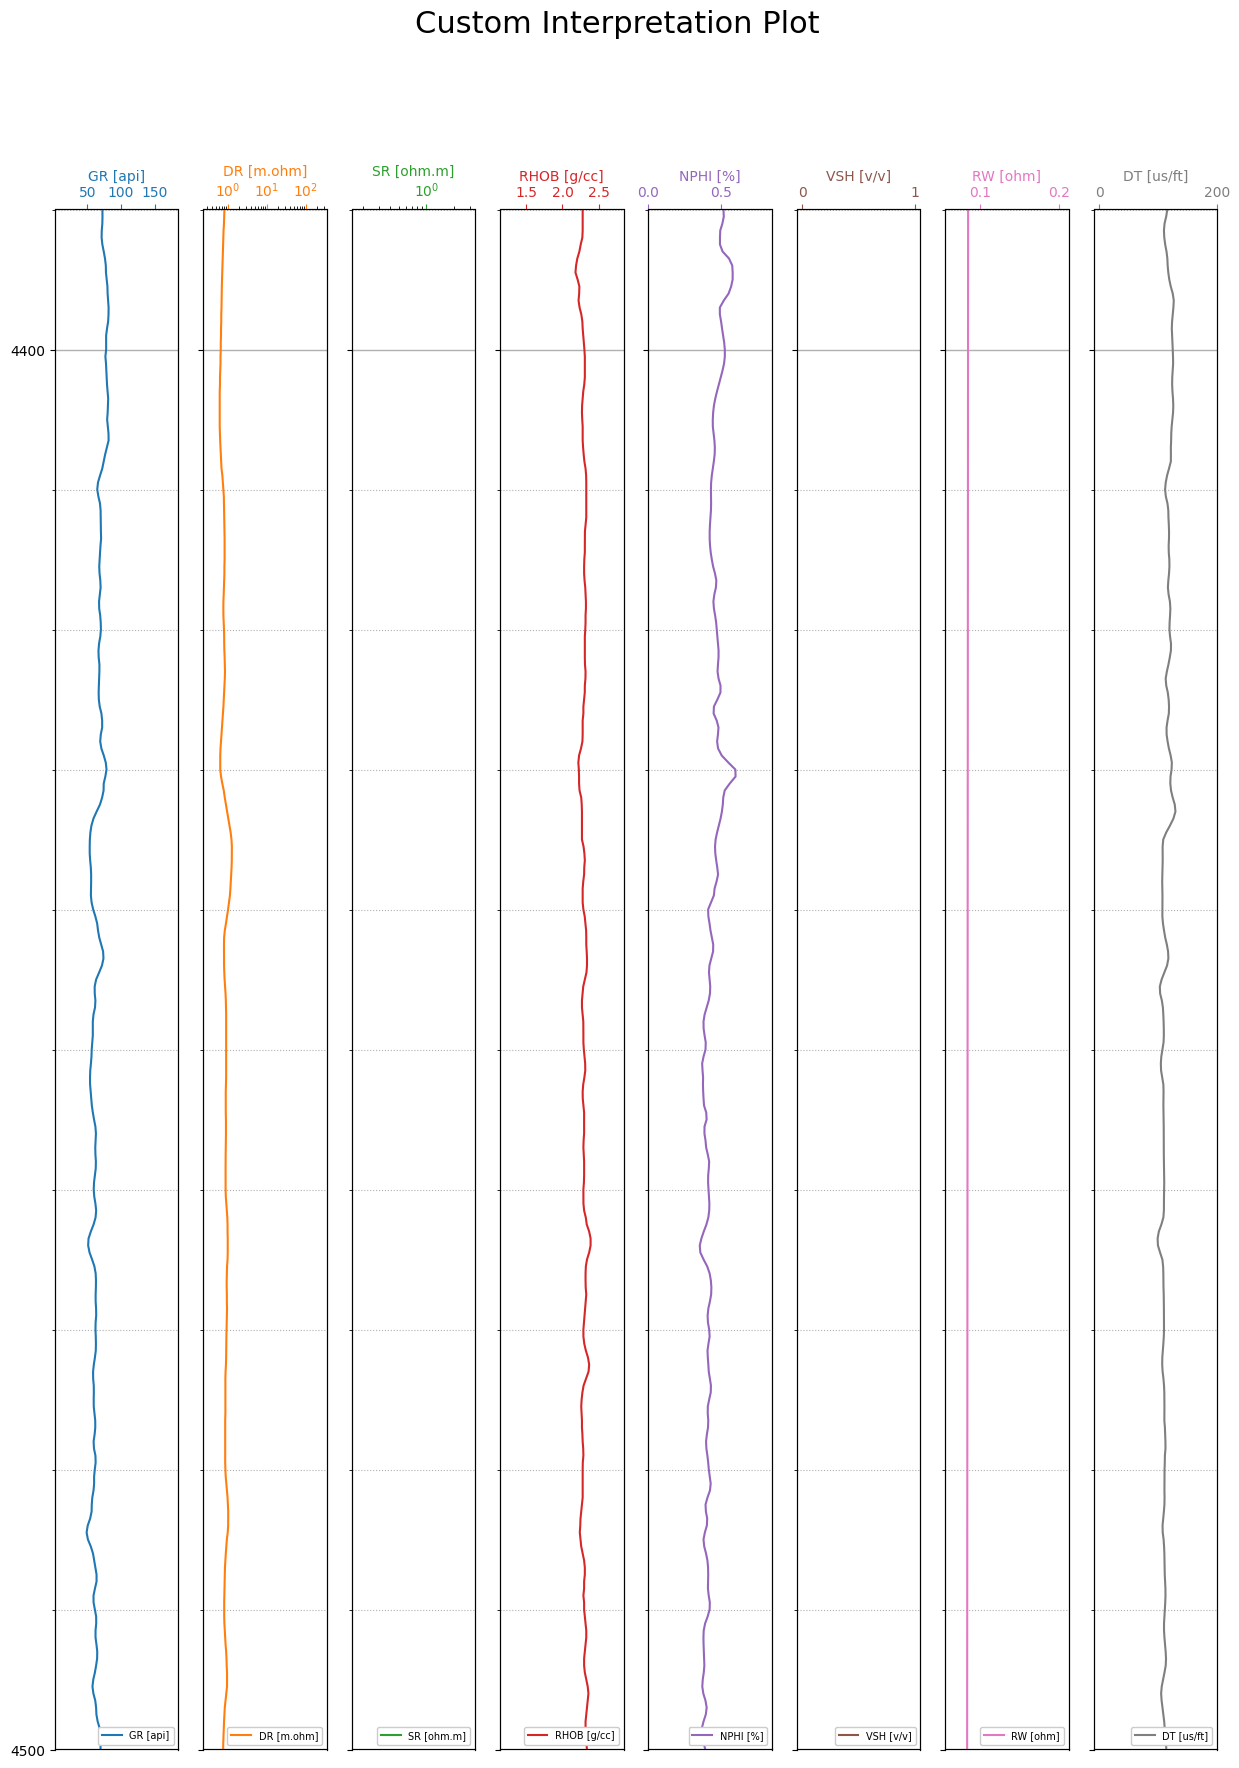

In [28]:
# Ori Unit ["api", "in", "mV", "m.ohm", "ohm.m", "ohm.m", "g/cc", "%", "us/ft"]
# custom_interpretation_plot(selected_data, depth_start, depth_end, "GR", "CALI", "SP", "DR", "MR", "SR", "NPHI", "RHOB", "DT", units=["API", "in", "mV", "ohm/m", "ohm.m", "ohm.m", "v/v", "g/cm³", "us/ft"])

custom_interpretation_plot(selected_data, depth_start, depth_end, "GR", "DR", "SR", "RHOB", "NPHI", "VSH", "RW", "DT", units=["api", "m.ohm", "ohm.m", "g/cc", "%", "v/v", "ohm", "us/ft"])

# Read Carefully before you proceed !!

# Explanation of Python Syntax and Methods Used in the Code

## 1. Creating New Columns in DataFrame
`dataframe["new_column_name"] = calculation_or_value`

## **6. CLAY VOLUME CALCULATION**
### **6.1. Single Method with Gamma Ray Log**

#### **The calculation of the volume of clay is carried out using five equation options, namely:**

**Linear Gamma Ray Equation:**
- *Formula:* $ VCL_{gr}=I_{gr} = \frac{gr_{log}-gr_{clean}}{gr_{clay}-gr_{clean}}$
- *Explanation:* Calculates the Volume of Clay $VCL_{gr}$ based on gamma ray log $gr_{log}$, clean sand gamma ray $gr_{clean}$, and clay gamma ray $gr_{clay}$.

**Larionov (Tertiary/Young Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.083(2^{3.7*I_{gr}}-1)$
- *Explanation:* Specifically designed for tertiary/young rocks, using the gamma ray index $I_{gr}$.

**Larionov (Old Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.33(2^{2\times I_{gr}}-1)$
- *Explanation* Tailored for old rocks, also utilizing the gamma ray index $I_{gr}$

**Clavier Equation:**
- *Formula:* $ VCL_{gr} = 1.7 - (3.38-(I_{gr}+0.7)^2)^{\frac{1}{2}} $
- *Explanation:* Involves a square root term and is based on the gamma ray index $I_{gr}$.

**Steiber Equation:**
- *Formula:* $ VCL_{gr} = 0.5(\frac{I_{gr}}{1.5-I_{gr}})$
- *Explanation:* Includes a ratio of the gamma ray index $I_{gr}$.

In [29]:
def vclgr(gr_log, gr_clean, gr_clay, correction=None):

    igr=(gr_log-gr_clean)/(gr_clay-gr_clean)
    vclgr_larionov_young=0.083*(2**(3.7*igr)-1)
    vclgr_larionov_old=0.33*(2**(2*igr)-1)
    vclgr_clavier=1.7-(3.38-(igr+0.7)**2)**0.5
    vclgr_steiber=0.5*igr/(1.5-igr)

    if correction == "young":
        vclgr=vclgr_larionov_young
    elif correction == "older":
        vclgr=vclgr_larionov_old
    elif correction=="clavier":
        vclgr=vclgr_clavier
    elif correction=="steiber":
        vclgr=vclgr_steiber
    else:
        vclgr=igr
    return vclgr

### **6.2. Single Method with Spontaneous Potential Log:**

The volume of clay $VCL_{sp}$ can be determined using the Spontaneous Potential (SP) log with the following equation:

$$VCL_{sp} = \frac{sp_{log} - sp_{clean}}{sp_{clay} - sp_{clean}}$$

- **Formula Explanation:**
  - $VCL_{sp}$: Volume of Clay using Spontaneous Potential.
  - $sp_{log}$: Spontaneous Potential log value.
  - $sp_{clean}$: SP value in clean formations.
  - $sp_{clay}$: SP value in clay-rich formations.

This equation provides a method for estimating the volume of clay based on the SP log measurements, where the SP log is compared to clean and clay values.


In [30]:
def vclsp(sp_log, sp_clean, sp_clay):
    vclsp=(sp_log-sp_clean)/(sp_clay-sp_clean)
    return vclsp

### **6.3. Single Method with Resistivity Log:**

The volume of clay $V_{rt}$ can be calculated using the Resistivity (RT) log with the following equation:

$$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

If $rt_{log} > 2 \times rt_{clay}$, then the volume of clay $VCL_{rt}$ is calculated as follows:

$$VCL_{rt} = 0.5(2 \times V_{rt})^{(0.67(V_{rt} + 1))}$$

- **Condition Explanation:**
  - $rt_{log}$ greater than twice $rt_{clay}$ triggers the second part of the calculation.

This method provides a way to estimate the volume of clay based on the Resistivity log, with a condition for specific scenarios where $rt_{log}$ exceeds a threshold relative to $rt_{clay}$.


In [68]:
def vclrt(rt_log, rt_clean, rt_clay):
    vrt = np.where( (rt_log == 0) | (rt_clean == rt_clay),
      np.nan,
      (rt_clay/rt_log)*(rt_clean-rt_log)/(rt_clean-rt_clay)
    )

    vclrt = np.where(rt_log > 2* rt_clay,
        0.5 * (2 * vrt)** (0.67*(vrt+1)),
        vrt
    )
    return vclrt

### **6.4. Dual Method with N-D Crossplot**
Dual methods involve the utilization of neutron-density crossplots, which are based on the correlation between neutron and density measurements. These crossplots depict the identification of a 'clean line' and a 'clay point,' as illustrated in the accompanying graphs.
1. Clean Line: The clean line on the neutron-density crossplot typically represents a linear trend that corresponds to rocks with minimal clay content. Rocks along this line have a consistent ratio of neutron and density measurements. This could correspond to sandstones or other clean, mineral-rich formations.

2. Clay Point: The clay point is a marker on the crossplot that corresponds to clay-rich formations. These formations will exhibit different neutron and density measurements compared to the clean line due to their higher clay content.

The terms **term1** and **term2** are defined as follows:

$$
\text{term1} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{log}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{log}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

$$
\text{term2} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clay}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{clay}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$

The volume of clay and neutron-density (\(VCL_{nd}\)) is then calculated as:

$$
VCL_{nd} = \frac{\text{term1}}{\text{term2}}
$$

- **Variables Explanation:**
  - $\rho_{\text{clean1}}$, $\rho_{\text{clean2}}$: Density values in clean formations.
  - $\rho_{\text{log}}$: Density log value.
  - $\text{neut}_{\text{clean1}}$, $\text{neut}_{\text{clean2}}$: Neutron-density values in clean formations.
  - $\text{neut}_{\text{log}}$: Neutron-density log value.
  - $\text{neut}_{\text{clay}}$: Neutron-density value in clay-rich formations.


This equation provides a method for calculating the volume of clay and neutron-density based on a neutron-density crossplot with density and neutron-density log measurements and values in clean formations.


In [69]:
def vclnd(neut_log,den_log,neut_clean1,den_clean1,neut_clean2,den_clean2,neut_clay,den_clay):
    term1 = (den_clean2-den_clean1)*(neut_log-neut_clean1)-(den_log-den_clean1)*(neut_clean2-neut_clean1)
    term2 =(den_clean2-den_clean1)*(neut_clay-neut_clean1)-(den_clay-den_clean1)*(neut_clean2-neut_clean1)
    vclnd = term1/term2
    return vclnd

### **6.5. Display for Traject and Histogram (GR and SP), N-D Crossplot, and VCL**
Several displays will be generated, including GR, SP vs. DEPTH track, histograms, neutron-density crossplot, and VCL track. These displays serve the purpose of observing and selecting the suitable parameters for distinguishing between clay-rich and clean formations. Additionally, they will allow for a comparison of the outcomes obtained from the various VCL calculation methods mentioned previously.

#### **6.5.1. VCL Plot Function** <br>

In [51]:
def vcl_plot(logs, depth_start, depth_end, gr_clean=None, gr_clay=None,
             neut_clean1=None, den_clean1=None, neut_clean2=None,
             den_clean2=None, neut_clay=None, den_clay=None,
             sp_clean=None, sp_clay=None, rhob_axis=[1.5,2.8], nphi_axis=[0,1]):
    """
    Plot volume of clay from different methods with handling for missing data

    Parameters:
    -----------
    logs : pandas DataFrame
        Well log data containing depth and measurement curves
    depth_start, depth_end : float
        Depth range for plotting
    *_clean, *_clay : float, optional
        Clean and clay points for different methods
    """

    # Create figure and gridspec
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle('Volume of clay from different methods', fontsize=14)
    fig.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)

    gs = gridspec.GridSpec(4, 3)

    # Initialize subplots
    ax1 = fig.add_subplot(gs[:, 0])  # All rows, column 1
    ax2 = fig.add_subplot(gs[0, 1])  # Row 1, column 2
    ax3 = fig.add_subplot(gs[1, 1])  # Row 2, column 2b
    ax4 = fig.add_subplot(gs[2, 1])  # Row 3, column 2
    ax5 = fig.add_subplot(gs[3, 1])  # Row 4, column 2
    ax6 = fig.add_subplot(gs[:, 2], sharey=ax1)  # All rows, column 3

    # Check for depth column
    depth_col = next((col for col in ['DEPT', 'DEPTH', 'MD'] if col in logs.columns), None)
    if depth_col is None:
        raise ValueError("No depth column found in logs")

    # Plot GR and SP (if available)
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_ylabel('DEPTH')

    if 'GR' in logs.columns:
        ax1.plot(logs.GR, logs[depth_col], color='green')
        ax1.set_xlabel('GR [api]', color='green')

    if 'SP' in logs.columns:
        ax11 = ax1.twiny()
        ax11.plot(logs.SP, logs[depth_col], color='blue')
        ax11.set_xlabel("SP [mV]", color='blue')

    if ' DR' in logs.columns:
        ax12 = ax1.twiny()
        ax12.plot(logs.DR, logs[depth_col], color='purple')
        ax12.set_xlabel('RT [ohm]', color='purple')

    # Histograms
    curves_to_plot = {
        'GR': ('green', ax2, 'GR [api]'),
        'SP': ('blue', ax3, 'SP [mV]'),
        'DR': ('gray', ax4, 'DR [m.ohm]')
    }

    for curve, (color, ax, xlabel) in curves_to_plot.items():
        if curve in logs.columns:
            ax.hist(logs[curve].dropna(), bins=15, color=color)
            ax.set_xlabel(xlabel)
            ax.set_ylabel('Frequency')

    # N-D Crossplot (if both NPHI and RHOB are available)
    if all(curve in logs.columns for curve in ['NPHI', 'RHOB']):
        points = ax5.scatter(logs.NPHI, logs.RHOB,
                           c=logs.GR if 'GR' in logs.columns else 'blue',
                           s=5, cmap="viridis")
        cbar = plt.colorbar(points)
        cbar.set_label('GR [API]', rotation=90, size=5)
        ax5.set_xlabel('NPHI [%]')
        ax5.set_ylabel('RHOB [g/cc]')
        ax5.invert_yaxis()
        ax5.invert_xaxis()
        ax5.grid(True)

        # Add axis limits (set constraints here)
        ax5.set_xlim(nphi_axis)  # Example for NPHI, adjust based on your data
        ax5.set_ylim(rhob_axis)

        # Plot clean and clay points if provided
        if all(v is not None for v in [neut_clean1, den_clean1, neut_clean2, den_clean2]):
            ax5.plot([neut_clean1, neut_clean2], [den_clean1, den_clean2],
                    marker='o', color='black', linewidth=1)
            ax5.text(neut_clean1, den_clean1, 'clean point 1', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))
            ax5.text(neut_clean2, den_clean2, 'clean point 2', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))

        if neut_clay is not None and den_clay is not None:
            ax5.plot(neut_clay, den_clay, 'ro', color='black', linewidth=1)
            ax5.text(neut_clay, den_clay, 'clay point', fontsize=6,
                    bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8))

    # Plot VCL values
    vcl_curves = {
        'VCLGR': ('green', 'VCLGR'),
        'VCLND': ('red', 'VCLND'),
        'VCLSP': ('blue', 'VCLSP'),
        'VCLRT': ('purple', 'VCLRT')
    }

    for curve, (color, label) in vcl_curves.items():
        if curve in logs.columns:
            ax6.plot(logs[curve], logs[depth_col], label=label, color=color)

    ax6.legend(loc='best', fontsize='x-small')
    ax6.set_xlim(0, 1)
    ax6.set_ylim(depth_start, depth_end)
    ax6.invert_yaxis()
    ax6.grid(True)
    ax6.set_xlabel('VCL [v.v]')

    # return fig

## **Define Logs variable for Calculations**

In [34]:
logs=selected_data[(selected_data.DEPT >= depth_start) & (selected_data.DEPT <= depth_end)]

In [35]:
logs.columns

Index(['WELL', 'DEPT', 'GR', 'CALI', 'MR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT',
       'VSH', 'RW', 'core_por', 'core_perm'],
      dtype='object')

### **6.6. Clay Volume Calcultion Function**

#### **6.6.1. Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both
- Minimum (clean) and maximum (clay) values of SP for both
- Minimum (clean) and maximum (clay) values of RT for both

To start with, simply guess any numbers. Then, refer to the crossplot results in section 5.5.3

In [70]:
# Clean point 1 (typical for a dense, clean rock like limestone)
neut_clean1 = 0.1  # NPHI of 0.1 (low porosity)
den_clean1 = 2.45  # RHOB of 2.45 g/cc (dense rock)

# Clean point 2 (moderate porosity, consolidated formation)
neut_clean2 = 0.25  # NPHI of 0.25 (moderate porosity)
den_clean2 = 2.0   # RHOB of 2.0 g/cc (consolidated, possibly sandstone)

# Clay point (high density, low porosity)
neut_clay = 0.8   # NPHI of 0.05 (low porosity, more clay)
den_clay = 2.65    # RHOB of 2.65 g/cc (typical for clay-rich formations)


gr_clean, gr_clay = logs.GR.min(), logs.GR.max()
rt_clean, rt_clay = logs.DR.max(), logs.DR.min()
if "SP" in logs.columns and logs["GR"].corr(logs["SP"]) > 0:
    sp_clean, sp_clay = logs.SP.min(), logs.SP.max() #In the case of being parallel to the GR, then (the smallest SP, the largest SP)
elif "SP" in logs.columns and logs["GR"].corr(logs["SP"]) < 0:
    sp_clean, sp_clay = logs.SP.max(), logs.SP.min() #If not parallel to the Gamma Ray, then (maximum SP, minimum SP).

#### **6.6.2. Do the Clay Volume Calculation**

In [76]:
# Alternatif (jangan dulu dipakai)
logs['VCLGR'] = vclgr(logs.GR, gr_clean, gr_clay, correction="older")
logs['VCLRT'] = vclrt(logs.DR, rt_clean, rt_clay)
logs['VCLND'] = vclnd(logs.NPHI, logs.RHOB, neut_clean1, den_clean1, neut_clean2, den_clean2, neut_clay, den_clay)

In [72]:
logs.columns

Index(['WELL', 'DEPT', 'GR', 'CALI', 'MR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT',
       'VSH', 'RW', 'core_por', 'core_perm', 'VCLGR', 'VCLND', 'VCLRT', 'VCL'],
      dtype='object')

#### **6.6.3. Extract and revise the clean and clay parameter from the Neutron-Density Crossplot**

- Define the clean line and clay point. This is done for VCL (Volume of Clay) calculations using the Neutron Density Crossplot.
- After that, return to 5.6.1 if the clean line and clay point are considered inaccurate on the plot

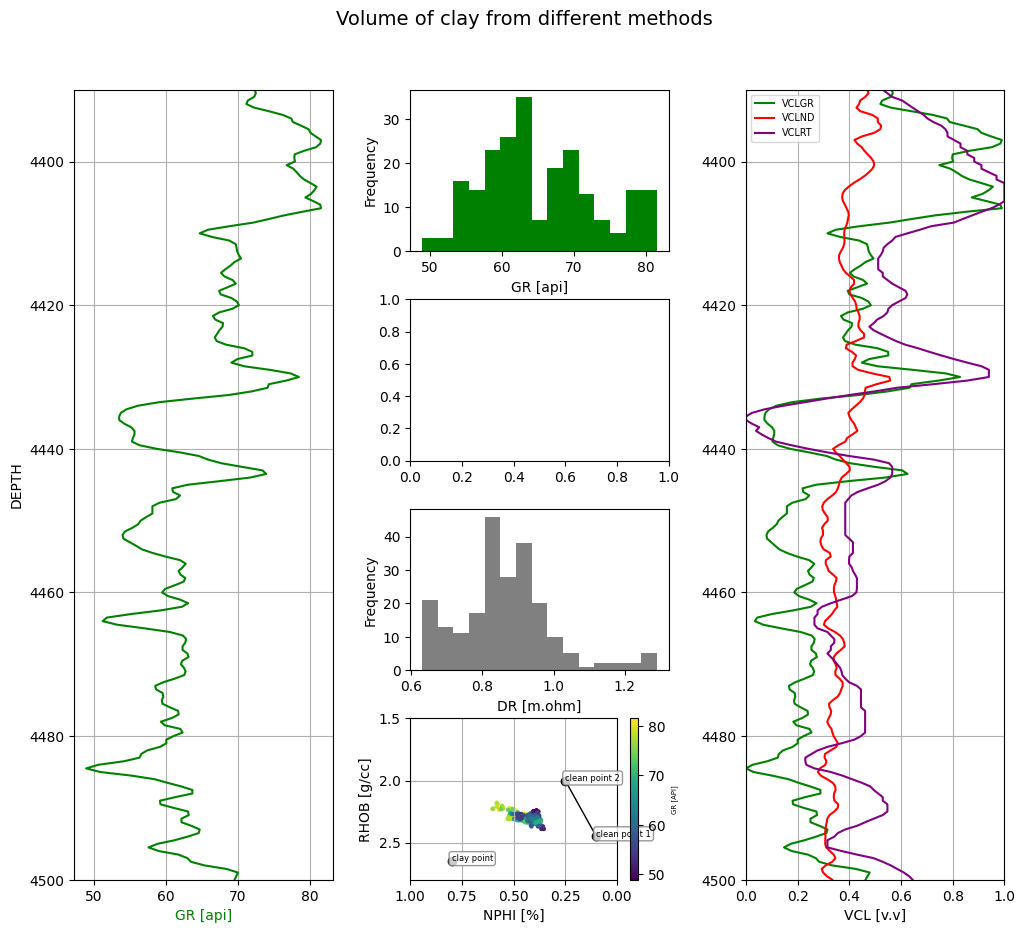

In [77]:
vcl_plot(
    logs, 
    depth_start, 
    depth_end,
    gr_clean,
    gr_clay,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
    rhob_axis=[2.8, 1.5],
    nphi_axis=[1,0]
    )

### **6.7 Choose the Best VCL**

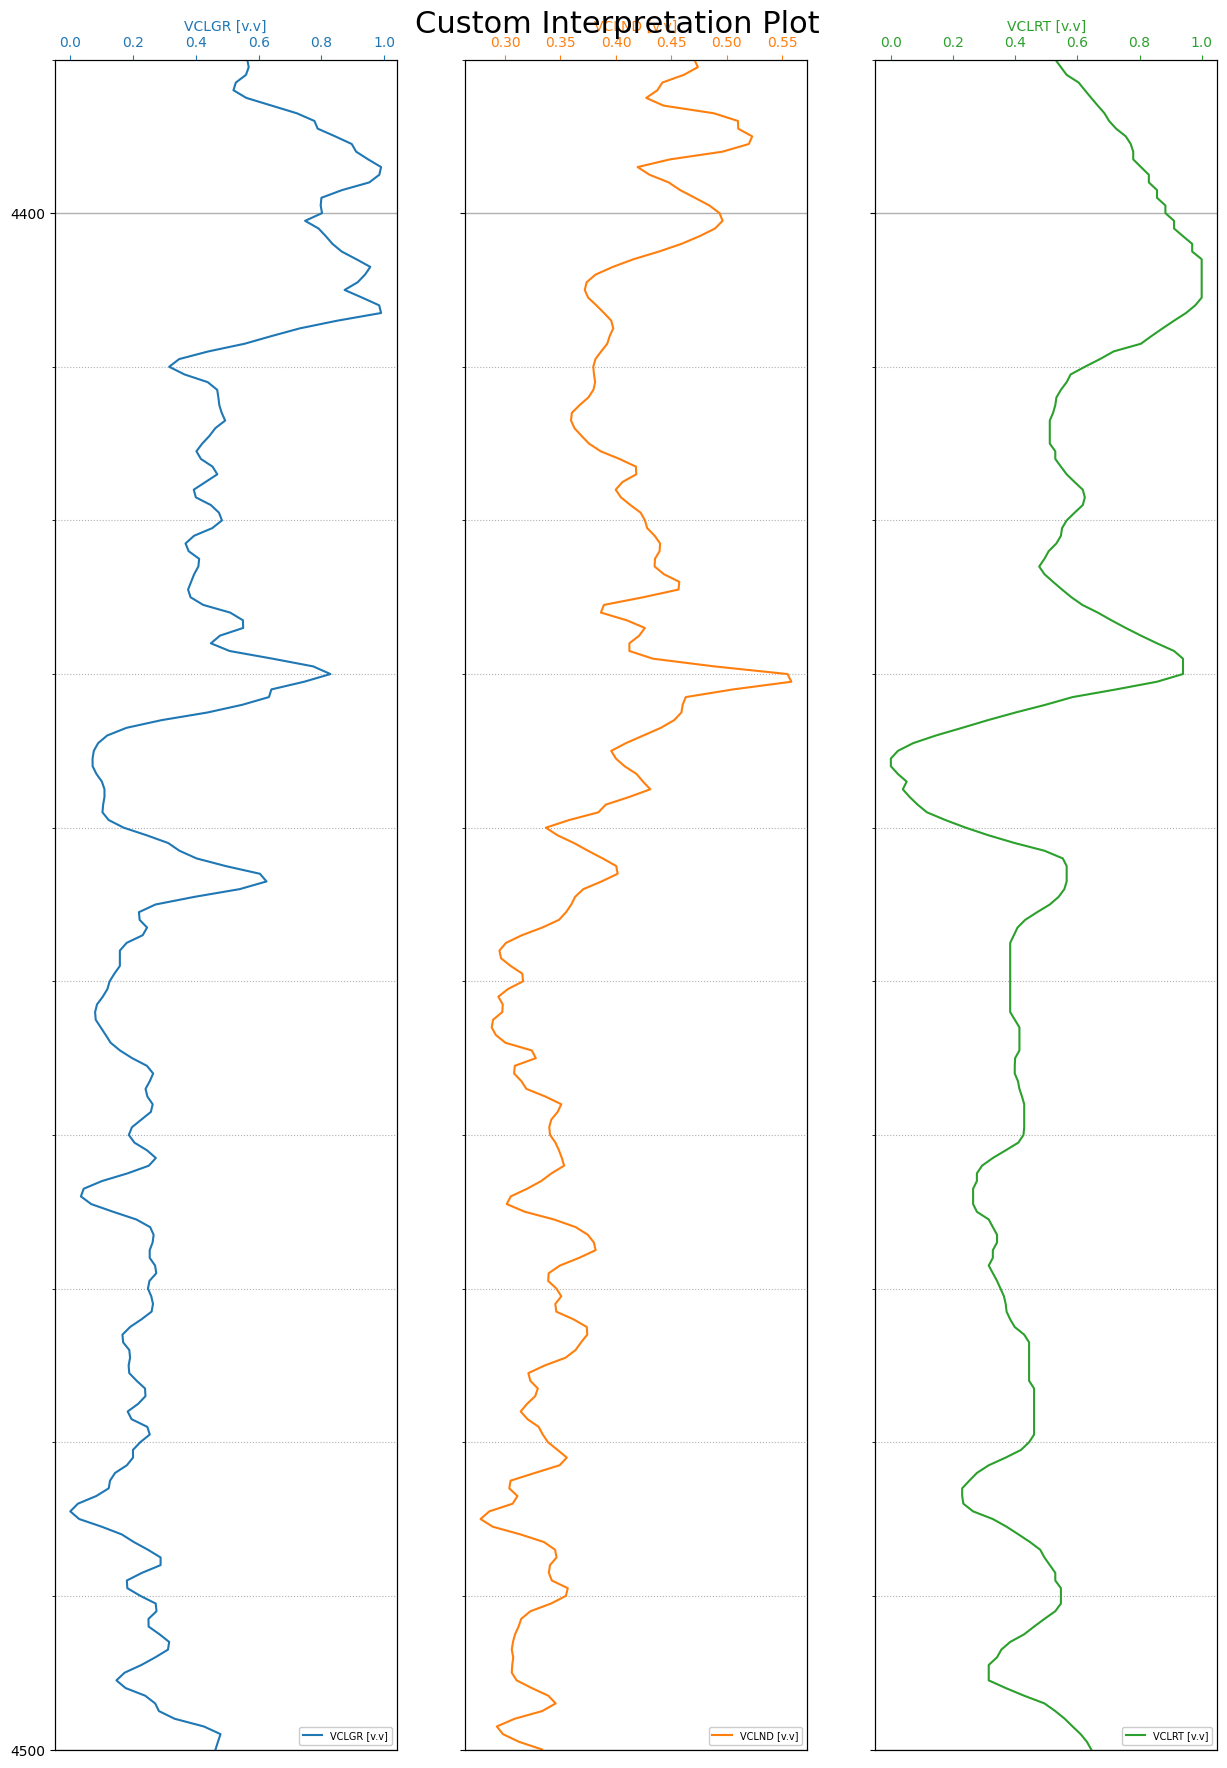

In [78]:
custom_interpretation_plot(logs, depth_start, depth_end, "VCLGR", "VCLND", "VCLRT", units=["v.v", "v.v", "v.v"])

To make the understanding easier, we will treat VCLGR as equivalent to VCL.
Alternatively, from 2 sub plot above, we can view vcl as the smallest value derived from various techniques, where VCL equals the minimum among VCLGR, VCLSP, and VCLND.

In [54]:
logs['VCL']=logs['VCLRT']

## **7. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

### **7.1. Shale Porosity Equation**
**Shale porosity with sonic Log:** <br>
$\phi_{shale[sonic]} = \frac{\Delta T_{sh}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Shale porosity with density log:** <br>
$\phi_{shale[density]} = \frac{\rho _{sh}-\rho _{ma}}{\rho _{fl}-\rho _{ma}}$

*Formula Explanation:*
- $\phi_{shale[sonic]}$: Shale porosity with sonic Log.
- $\phi_{shale[density]}$: Shale porosity with density log.
- $\Delta T_{sh}$: Sonic transit time in shale.
- $\Delta T_{ma}$: Sonic transit time in matrix.
- $\Delta T_{fl}$: Sonic transit time in fluid.
- $\rho _{sh}$: Density in shale.
- $\rho _{ma}$: Density in matrix.
- $\rho _{fl}$: Density in fluid.

In [79]:
#Willie-TimeAverage
def phis_shale(dt_sh, dt_ma, dt_fl):
    phis_shale = (dt_sh-dt_ma)/(dt_fl-dt_ma)
    return phis_shale

In [80]:
def phid_shale(den_sh, den_ma, den_fl):
    phid_shale = (den_sh - den_ma) / (den_fl - den_ma)
    return phid_shale

### **7.2. Wyllie Time-Average Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Wyllie]} = \frac{1}{cp}\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][Wyllie]} = {\phi_{[sonic][Wyllie]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Wyllie]}$: Porosity in the part under review using Wyllie Time-Average equation.
- $\phi_{corr[sonic][Wyllie]}$: Effective porosity considering volume of clay.

In [81]:
def phis_w(dt_log, dt_ma, dt_fl, cp):
    phis_w=(1/cp)*(dt_log-dt_ma)/(dt_fl-dt_ma)
    return phis_w

In [82]:
def phis_w_sh_corr(dt_log, dt_ma, dt_fl, cp, dt_sh, vcl):
    phis_w_sh_corr = phis_w(dt_log,dt_ma,dt_fl,cp) - vcl*phis_shale(dt_sh,dt_ma,dt_fl)
    return phis_w_sh_corr

### **7.3. Raymer Hunt Gardner Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Raymer]} = \alpha\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{log}}$

**Effective porosity:** <br>
$\phi_{corr[sonic][raymer]} = {\phi_{[sonic][raymer]}}-{v_{cl}\times\phi_{shale[sonic]}}$

*Formula Explanation:*
- $\phi_{[sonic][Raymer]}$: Porosity in the part under review using Raymer Hunt Gardner equation.
- $\phi_{corr[sonic][raymer]}$: Effective porosity considering volume of clay.

In [83]:
#Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_ma, alpha):
    phis_rhg=(alpha)*(dt_log-dt_ma)/(dt_log)
    return phis_rhg

In [84]:
def phis_rhg_sh_corr(dt_log, dt_ma, dt_sh, vcl,alpha,dt_fl):
    phis_rhg_sh_corr = phis_rhg(dt_log, dt_ma, alpha) - vcl * phis_shale(dt_sh, dt_ma, dt_fl)
    return phis_rhg_sh_corr

### **7.4. Density Equation**
**Porosity in the part under review:** <br>
$\phi_{[density]} = \frac{\rho_{log}-\rho_{ma}}{\rho_{fl}-\rho_{ma}}$

**Effective porosity:** <br>
$\phi_{corr[density]} = {\phi_{[density]}}-{v_{cl}\times\phi_{shale[density]}}$

*Formula Explanation:*
- $\phi_{[density]}$: Porosity in the part under review using density log.
- $\phi_{corr[density]}$: Effective porosity considering volume of clay.

In [85]:
#Density
def phid(rho_log, rho_m, rho_f, new=True):
    if new:
      phid = (rho_m - rho_log)/(rho_m - rho_f)
    else:
      phid = (rho_log - rho_m) / (rho_f - rho_m)
    return phid

def phi_simandoux(vsh, phid):
  base_eq = (vsh**2)+(phid**2)
  phi = np.sqrt(base_eq/2)

  return phi

In [86]:
def phid_sh_corr(den_log, den_ma, den_fl, den_sh, vcl):
    phid_sh_corr = phid(den_log, den_ma, den_fl) - vcl * phid_shale(den_sh, den_ma, den_fl)
    return phid_sh_corr

### **7.5. Neutron Equation**
**Effective porosity:** <br>
$\phi_{[corr][neutron]} = \frac{nphi_{log}-vcl\times nphi_{shale}}{100}$

*Formula Explanation:*
- $\phi_{[corr][neutron]}$: Effective porosity using neutron log.
- $nphi_{log}$: Neutron porosity log value.
- $vcl$: Volume of clay.

In [87]:
# Neutron
def phin_sh_corr(neut, neut_sh, vcl):
    phin_sh_corr = (neut-vcl*neut_sh)/100
    return phin_sh_corr

### **7.6. Neutron-Density Equation**
$\phi_{[neutronxdensity]} = \frac{\phi_{nshc} + \phi_{dshc}}{2}$

$\phi_{[corr][neutronxdensity]} = \sqrt{\frac{\phi_{n}^2 + \phi_{d}^2}{2}}$

*Formula Explanation:*
- $\phi_{[neutronxdensity]}$: Porosity using neutron-density combination.
- $\phi_{[corr][neutronxdensity]}$: Effective porosity considering neutron-density combination.
- $\phi_{nshc}$, $\phi_{dshc}$: Neutron and density porosities in shale and clean formations.
- $\phi_{n}$, $\phi_{d}$: Neutron and density porosities.

In [88]:
#Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd= (phinshc + phidshc) / 2
    return phixnd
def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr= ((phin**2+phid**2)/2)**(0.5)    #for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr

### **7.7. Resistivity Equation**
**7.7.1. Volume of Clay using Resistivity log:** <br>
$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$

- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

### **7.7. Define the Parameter for Porosity Calculation**


In [89]:
#Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5/8
den_ma = 2.24
den_fl = 0.1
den_sh = den_clay

phis_sh=phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh=phis_shale(den_sh, den_ma, den_fl)
phin_sh=45

### **7.8. All Porosity Calculation**


In [90]:
# # 1. Poro calc with DT
logs['PHISw']=phis_w(logs.DT, dt_ma, dt_fl, cp)
logs['PHISwshc']=phis_w_sh_corr(logs.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL).clip(0,1)

logs['PHISrhg']=phis_rhg(logs.DT, dt_ma, alpha)
logs['PHISrhgshc']=phis_rhg_sh_corr(logs.DT, dt_ma, dt_sh, logs.VCL,alpha,dt_fl).clip(0,1)

# # 2. Poro calc with RHOB
logs['PHID']=phid(logs.RHOB, den_ma, den_fl, new=True)
logs['PHIDshc']=phid_sh_corr(logs.RHOB, den_ma, den_fl, den_sh, logs.VCL).clip(0,1)

# # 3. Poro calc for Simandoux using VSH param
logs['PHI_SIMANDOUX']=phi_simandoux(logs.VSH,logs.PHID).clip(0,1)

# # 4. Poro calc with NPHIN (Dual-method)
logs['PHIN']=(logs.NPHI/100).clip(0,1)
logs['PHINshc']=phin_sh_corr(logs.NPHI, phin_sh, logs.VCL).clip(0,1)

logs['PHIxND']=phixnd(logs.PHINshc,logs.PHIDshc).clip(0,1)

In [99]:
data[data["VSH"] > 0]

WELL    DEPT     GR   CALI      MR      DR      SR    NPHI   RHOB  \
3490  LL-4  1745.0  24.58  19.07  0.5582  0.3555  0.1742     NaN    NaN   
3491  LL-4  1745.5  29.57  21.48  0.5502  0.3733  0.2443     NaN    NaN   
3492  LL-4  1746.0  34.74  22.27  0.5347  0.7036  0.3155     NaN    NaN   
3493  LL-4  1746.5  37.45  22.16  0.4609  0.8212  0.3647     NaN    NaN   
3494  LL-4  1747.0  37.58  22.12  0.3755  0.8996  0.4093     NaN    NaN   
...    ...     ...    ...    ...     ...     ...     ...     ...    ...   
8164  LL-4  4082.0  71.89  12.82  0.8954  0.9600     NaN  0.4774  2.250   
8165  LL-4  4082.5  71.08  12.59  0.9120  1.0000     NaN  0.4620  2.240   
8166  LL-4  4083.0  70.37  12.57  0.9376  1.0400     NaN  0.4585  2.240   
8167  LL-4  4083.5  67.17  12.56  0.9796  1.0967     NaN  0.4669  2.240   
8168  LL-4  4084.0  61.26  12.49  1.0290  1.1633     NaN  0.4789  2.232   

         DT     VSH        RW  
3490    NaN  0.0214  0.131792  
3491    NaN  0.1018  0.131778  
3492    NaN  0.1851  0.131765  
3493    NaN  0.2288  0.131751  
3494    NaN  0.2309  0.131738  
...     ...     ...       ...  
8164  119.1  0.7838  0.088970  
8165  118.7  0.7707  0.088963  
8166  119.1  0.7593  0.088957  
8167  121.2  0.7077  0.088951  
8168  122.6  0.6125  0.088945  

[4455 rows x 12 columns]

### **7.9 Choose the Best PHIE**

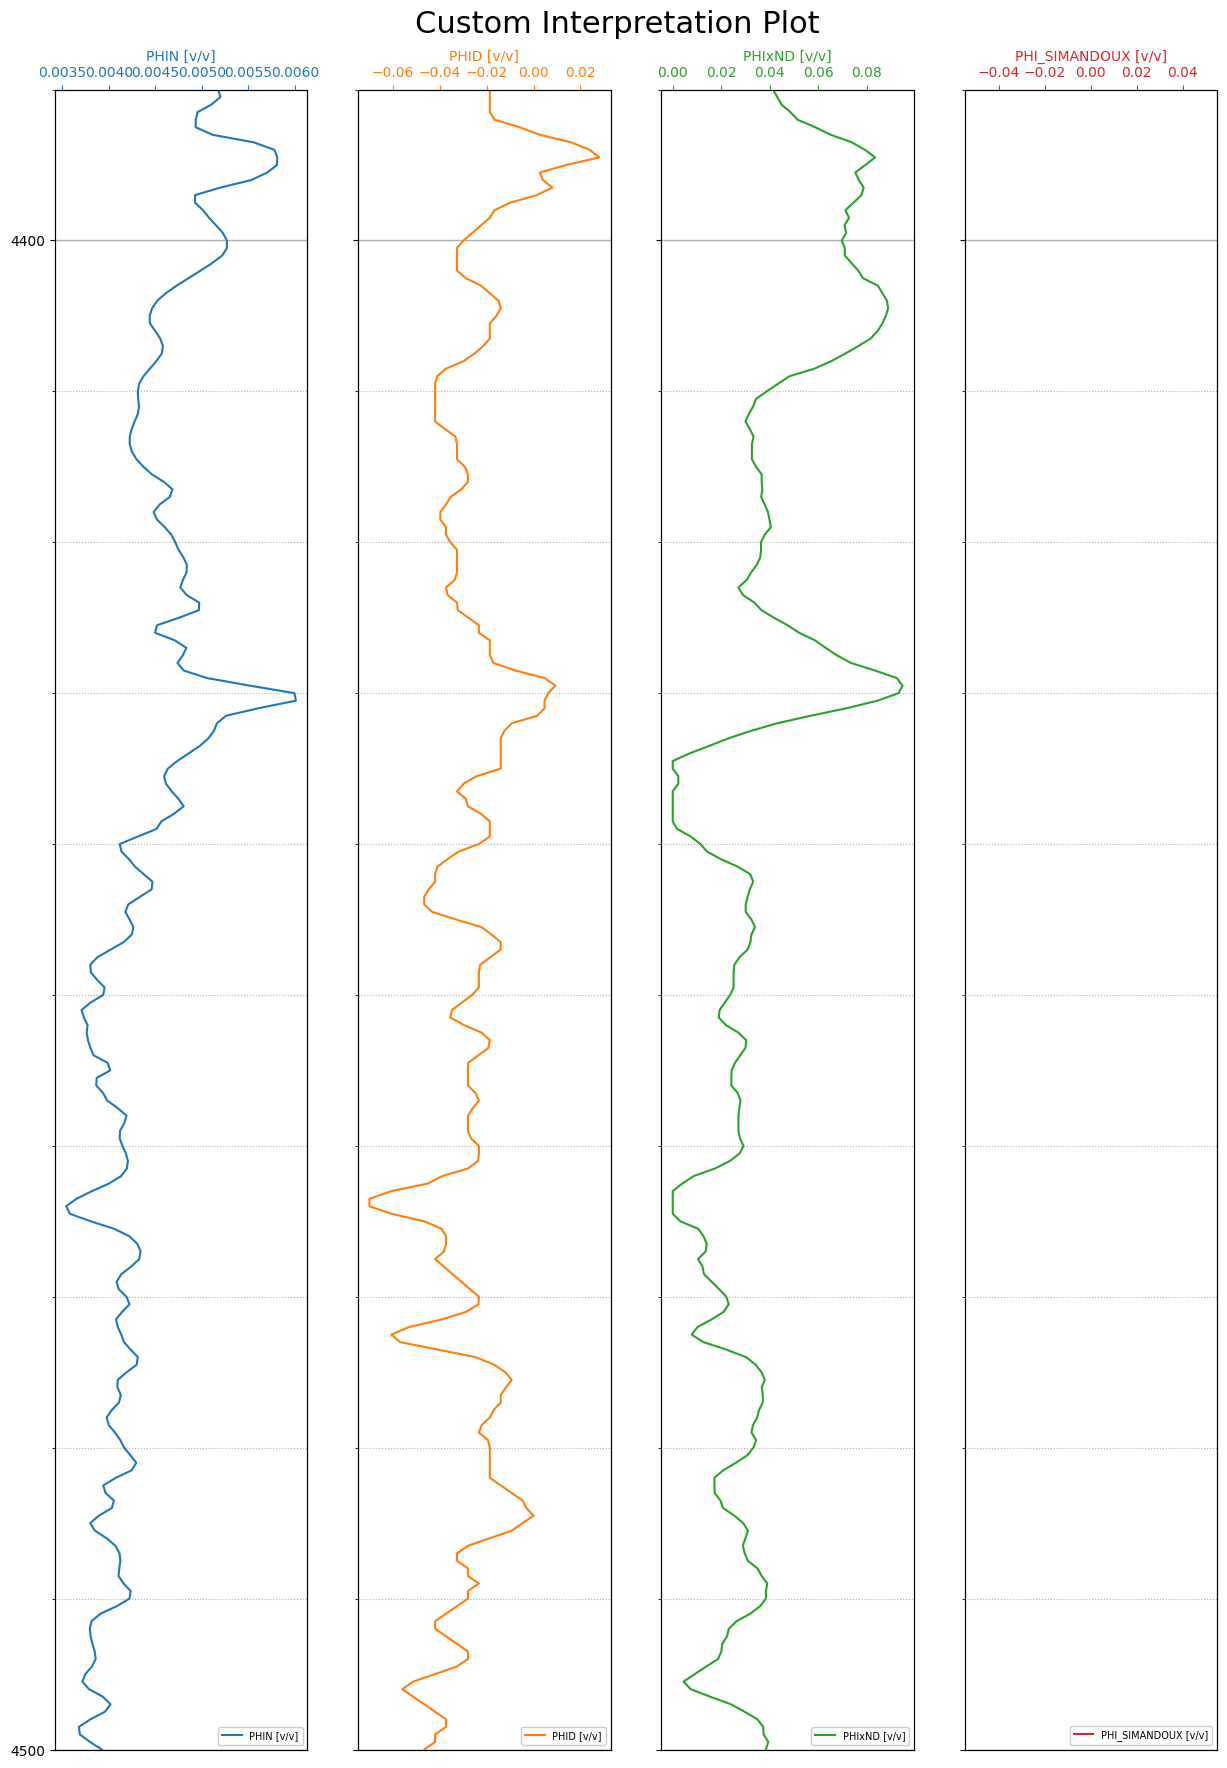

In [91]:
# Example usage:
custom_interpretation_plot(logs, depth_start, depth_end, "PHIN", "PHID", "PHIxND", "PHI_SIMANDOUX", units=["v/v", "v/v", "v/v", "v/v"])

In [100]:
# Choosing the best porosity calc for SW (waxman, indonesia, archie) calc later on this code
logs['PHIE']=logs['PHID']

## **8. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **8.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:

$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

In [144]:
def sw_archie(phi, Rt, Rw, a, m, n):
    if phi <= 0 or Rt <= 0 or Rw <= 0:
        return np.nan  # Invalid input leads to NaN, not a complex number
    try:
        Sw = (a * Rw / (phi**m * Rt))**(1/n)
        return Sw
    except ValueError:
        return np.nan


The equation can be transformed into a logarithmic expression and visualized on a log plot of RT against PHI:

$\log \phi = -\frac{1}{m} \log(R_t) - n \log(S_w) + \log(a\times R_w)$

In [102]:
def pickett_plot(logs, vcl_limit, a, rwa, m, n, z):
    plt.figure(figsize=(7,6))
    plt.title('Pickett Plot'+ ' for VCL < '+ str(int(vcl_limit*100)) + '%' + " and Rw = " + str(rwa) + " ohm.m")
    c = logs[z][logs.VCL<vcl_limit]
    plt.scatter(logs.DR[logs.VCL<vcl_limit], logs.PHIE[logs.VCL<vcl_limit],c=c, s=20, cmap="plasma")
    cbar = plt.colorbar()
    cbar.set_label(f'{z}')
    plt.xlim(0.1,1000)
    plt.ylim(0.01,1)
    plt.ylabel('PHIE [v/v]')
    plt.xlabel('DR [m.ohm]')
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phie_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phie_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phie_plot)):
            rt_result=((a*rwa)/(sw_plot[i]**n)/(phie_plot[j]**m))
            rt_plot[i,j]=rt_result
    for i in range(0,len(sw_plot)):
        plt.plot(rt_plot[i],phie_plot, label='SW '+str(int(sw_plot[i]*100))+'%')
        plt.legend (loc='best')

    plt.grid(True, which='both',ls='-',color='gray')

#### **8.1.1. Define the Paramater for Archie Water Saturation Calculation**

Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8.
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [103]:
a = 0.9
m = 1
n = 1.8
rt = 0.8

In [104]:
rwa_input = logs['RW'].median()

#### **8.1.2. Choose the Water Resistivity**

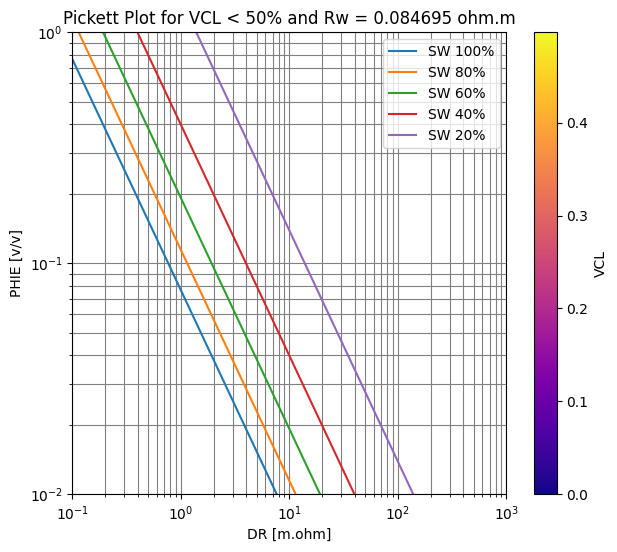

In [106]:
pickett_plot(logs, vcl_limit = 0.5, a = a, rwa = rwa_input, m = m, n = n, z = "VCL")

In [107]:
Rw = 0.12 # Water resistivity adjusted based on picket plot

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.

Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

#### **8.1.3. Calculate the Water Saturation using Archie**
and call it in order to have the result of saturation Swa. Clip the results between (0,1).

In [148]:
"""
Calculate water saturation using Archie's equation and clip values between 0 and 1.

Input Syntax:
-------------
- logs['Parameters'] or logs.Parameters -> if u want to use values from log data
- variable_name -> if want to calculate with pre-defined variable
Parameters:
-----------
logs : pandas DataFrame
    Well log data containing porosity and resistivity curves.
Rw : float
    Formation water resistivity.
rt : float
    True resistivity of the formation (e.g., deep resistivity reading like LLD or RT).
PHIE : pandas Series
    Effective porosity column from the logs DataFrame.
a, m, n : float
    Archie equation parameters:
        - a: Tortuosity factor.
        - m: Cementation exponent.
        - n: Saturation exponent.

Returns:
--------
SWarchie : pandas Series
    Water saturation values clipped to the range [0, 1].
"""
logs['SWarchie'] = logs.apply(lambda row: sw_archie(Rw, rt, row['PHIE'], a, m, n), axis = 1)
# logs['SWarchie'] = (sw_archie(Rw, rt, logs.PHIE, a, m, n))


Calculate the BVW (bulk volume of water):

In [149]:
"""
Calculate bulk volume water (BVW) and matrix fraction for well log data.

Parameters:
-----------
logs : pandas DataFrame
    Well log data containing porosity, water saturation, and clay volume curves.
SWarchie : pandas Series
    Water saturation calculated using Archie's equation.
PHIE : pandas Series
    Effective porosity.
VCL : pandas Series
    Volume of clay fraction.

Returns:
--------
BVW : pandas Series
    Bulk volume water, calculated as the product of water saturation and effective porosity.
matrix : pandas Series
    Matrix fraction, calculated as the remaining volume after subtracting clay volume and effective porosity from 1.
"""
logs['BVW'] = logs['SWarchie'] * logs['PHIE']
logs['matrix'] = 1 - logs['VCL'] - logs['PHIE']

### **8.2 Waxman-Smits Water Sturation Equation**

$B_{max} = 51.31\times log(T+460)-317.2$ <br>
$B = (1 - \frac{0.83}{exp(0.5/Rw)}) \times B_{max}$ <br>

$F = \frac{a}{\phi^m}$ <br>
$Swi = (F\times\frac{Rw}{Rt})^{\frac{1}{n}}$

**Iterate** <br>
$Sw = (\frac{F}{\frac{Rt}{(1 / Rw + (b * Qv / Swi))}}) ^ {\frac{1}{n}}$ <br>

$Sw = (F / Rt / (1 / Rw + (b * Qv / Swi))) ^ {\frac{1}{n}}$

In [150]:
def sw_waxman(Rw, Qv, a, m, n, Temp, Rt, Phi):
    try:
        # Input validation
        if Rw == 0 or Rt == 0 or Phi == 0 or n == 0:
            return np.nan

        Sw, Swi = 0.0, 0.0

        # Calculate Bmax and b
        Bmax = 51.31 * math.log(Temp + 460) - 317.2
        b = (1 - 0.83 / math.exp(0.5 / Rw)) * Bmax
        F = a / (Phi ** m)

        # Initial Swi calculation
        Swi = (F * Rw / Rt) ** (1 / n)

        # Protect against Swi being zero in the loop
        while abs(Sw - Swi) > 0.01 and Swi != 0:
            denominator = (1 / Rw + (b * Qv / Swi))
            if denominator == 0:
                return np.nan

            Sw = (F / Rt / denominator) ** (1 / n)
            Swi = Sw

        return Sw

    except:
        return np.nan

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [151]:
#Geothermal Gradient
mid_perf = 13950  #TVD
BHT_mid_perf = 192 #Fahrenheit
T_surf = 60 #Fahrenheit
T_gradient = (BHT_mid_perf-T_surf)/(mid_perf) #Fahrenheit/ft

#### **8.2.2. By using the same parameters as Archie, calculate the Wwter saturation using Waxman-Smits**


In [152]:
# Create new column 'CEC' and 'T' for SWwaxman Calc
logs["CEC"] = -47.619 * logs["VCL"] ** 2.0 + 61.429 * logs["VCL"]
logs["T"] = T_surf + T_gradient * logs["DEPT"]

In [137]:
"""
Calculate water saturation using the Waxman-Smits equation for each row of well log data.

Input Syntax:
-------------
- row['Parameters'] -> if u want to use values from log data
- variable_name -> if want to calculate with pre-defined variable
Parameters:
-----------
logs : pandas DataFrame
    Well log data containing porosity, resistivity, and cation exchange capacity (CEC) curves.
Rw : float
    Formation water resistivity.
CEC : float
    Cation exchange capacity of the rock, representing clay content's ability to exchange cations.
T : float
    Formation temperature in degrees Celsius.
DR : float
    Deep resistivity reading (e.g., LLD or RT).
PHIE : float
    Effective porosity.
a, m, n : float
    Waxman-Smits equation parameters:
        - a: Tortuosity factor.
        - m: Cementation exponent.
        - n: Saturation exponent.

Returns:
--------
SWwaxman : pandas Series
    Computed water saturation for each row using the Waxman-Smits model.
"""
logs['SWwaxman'] = logs.apply(
    lambda row: sw_waxman(Rw, row['CEC'], a, m, n, row['T'], row['DR'], row['PHIE']), axis=1
)

# logs['SWwaxman'] = sw_waxman(Rw, logs['CEC'], a,m,n, logs['T'], logs['DR'], logs['PHIE'])


# logs["SWwaxman"] = logs["SWwaxman"].clip(0,1) # uncomment this line if u want to make sure that the results is in range 0 to 1

In [153]:
logs.head()

WELL    DEPT     GR   CALI      MR    DR  SR    NPHI    RHOB       DT  \
8780  LL-4  4390.0  72.35  12.67  0.7551  0.83 NaN  0.5175  2.2800  115.767   
8781  LL-4  4390.5  72.47  13.13  0.7465  0.82 NaN  0.5199  2.2800  113.900   
8782  LL-4  4391.0  72.24  13.21  0.7379  0.81 NaN  0.5102  2.2800  111.120   
8783  LL-4  4391.5  71.37  12.63  0.7328  0.79 NaN  0.4954  2.2800  110.053   
8784  LL-4  4392.0  71.16  12.42  0.7278  0.78 NaN  0.4934  2.2757  110.640   

      ...    PHIxND      PHIE SWarchie BVW    matrix        CEC           T  \
8780  ...  0.041332 -0.018692      NaN NaN  0.489666  19.170471  101.539785   
8781  ...  0.043065 -0.018692      NaN NaN  0.471574  19.354726  101.544516   
8782  ...  0.044841 -0.018692      NaN NaN  0.453035  19.511192  101.549247   
8783  ...  0.048528 -0.018692      NaN NaN  0.414549  19.731499  101.553978   
8784  ...  0.051447 -0.016682      NaN NaN  0.392556  19.790251  101.558710   

                SWwaxman  SWindonesia  SWsimandoux  
8780  0.712996-0.845853j          NaN          NaN  
8781  0.716897-0.850004j          NaN          NaN  
8782  0.721387-0.855115j          NaN          NaN  
8783  0.732321-0.868514j          NaN          NaN  
8784  0.809068-0.972576j          NaN          NaN  

[5 rows x 37 columns]

### **8.3 Poupon-Laveaux (Indonesia) Water Sturation Equation**

In [154]:
def sw_indonesia(Rw, Rt, Poro, a, m, n, vcl, rsh):
    try:
        # Input validation
        if Rt == 0 or rsh == 0 or a == 0 or n == 0:
            return np.nan

        # Calculate terms
        vcl_term = vcl ** (1 - (0.5 * vcl))
        poro_term = (Poro ** m) / (a * Rw)

        # Denominator calculation
        denominator = (vcl_term / (rsh ** 0.5)) + (poro_term ** 0.5)

        if denominator == 0:
            return np.nan

        # Final calculation
        Sw_indonesia = ((1/Rt) / denominator) ** (2/n)

        # Check if result is valid
        if not 0 <= Sw_indonesia <= 1:
            return np.nan

        return Sw_indonesia

    except:
        return np.nan

In [155]:
"""
Calculate water saturation using the Indonesia model for each row of well log data.

Input Syntax:
-------------
- row['Parameters'] -> if u want to use values from log data
- variable_name -> if want to calculate with pre-defined variable
Parameters:
-----------
logs : pandas DataFrame
    Well log data containing depth and measurement curves.
RW : float
    Formation water resistivity.
DR : float
    Deep resistivity reading (e.g., LLD or RT).
PHIE : float
    Effective porosity.
a, m, n : float
    Archie equation parameters:
        - a: Tortuosity factor.
        - m: Cementation exponent.
        - n: Saturation exponent.
VCL : float
    Volume of clay fraction.
rsh : float, optional
    Shale resistivity, default is 100 ohm-m.

Returns:
--------
SWindonesia : float
    Computed water saturation for each row.
"""
logs["SWindonesia"] = logs.apply(
    lambda row: sw_indonesia(Rw, row['DR'], row['PHIE'], a, m, n, row['VCL'], rsh=100), axis=1
)


# logs["SWindonesia"] = logs["SWindonesia"].clip(0,1) # uncomment this line if u want to make sure that the results is in range 0 to 1

### **8.4 Simandoux SW**

In [156]:
def sw_simandoux(Rw, Rt, Vsh, Poro, a, m, n, Rsh):
    F = a / (Poro ** m)
    X = Vsh / Rsh
    term = X ** 2 + (4 / a) * F * Rw / Rt
    Sw_modsim = ((F * (Rw / 2) * (np.sqrt(term) - X)) ** (2 / n))

    return Sw_modsim


In [157]:
"""
Calculate water saturation using the Simandoux model and clip values between 0 and 1.

Input Syntax:
-------------
- logs['Parameters'] or logs.Parameters -> if u want to use values from log data
- variable_name -> if want to calculate with pre-defined variable
Parameters:
-----------
logs : pandas DataFrame
    Well log data containing porosity, resistivity, and shale volume curves.
Rw : float
    Formation water resistivity.
rt : float
    True resistivity of the formation (e.g., deep resistivity reading like DR, LLD or RT).
VSH : pandas Series
    Volume of shale fraction.
PHI_SIMANDOUX : pandas Series
    Porosity used in the Simandoux model.
a, m, n : float
    Simandoux equation parameters:
        - a: Tortuosity factor.
        - m: Cementation exponent.
        - n: Saturation exponent.
rsh : pandas Series (for this case im using DR datas u can change it if u want)
    shale resistivity.

Returns:
--------
SWsimandoux : pandas Series
    Water saturation calculated using the Simandoux model, clipped to the range [0, 1].
"""
logs["SWsimandoux"] = sw_simandoux(Rw, rt, logs.VSH, logs.PHI_SIMANDOUX, a, m, n, logs.DR).clip(0, 1)

### **8.5 Choose the Best SW**

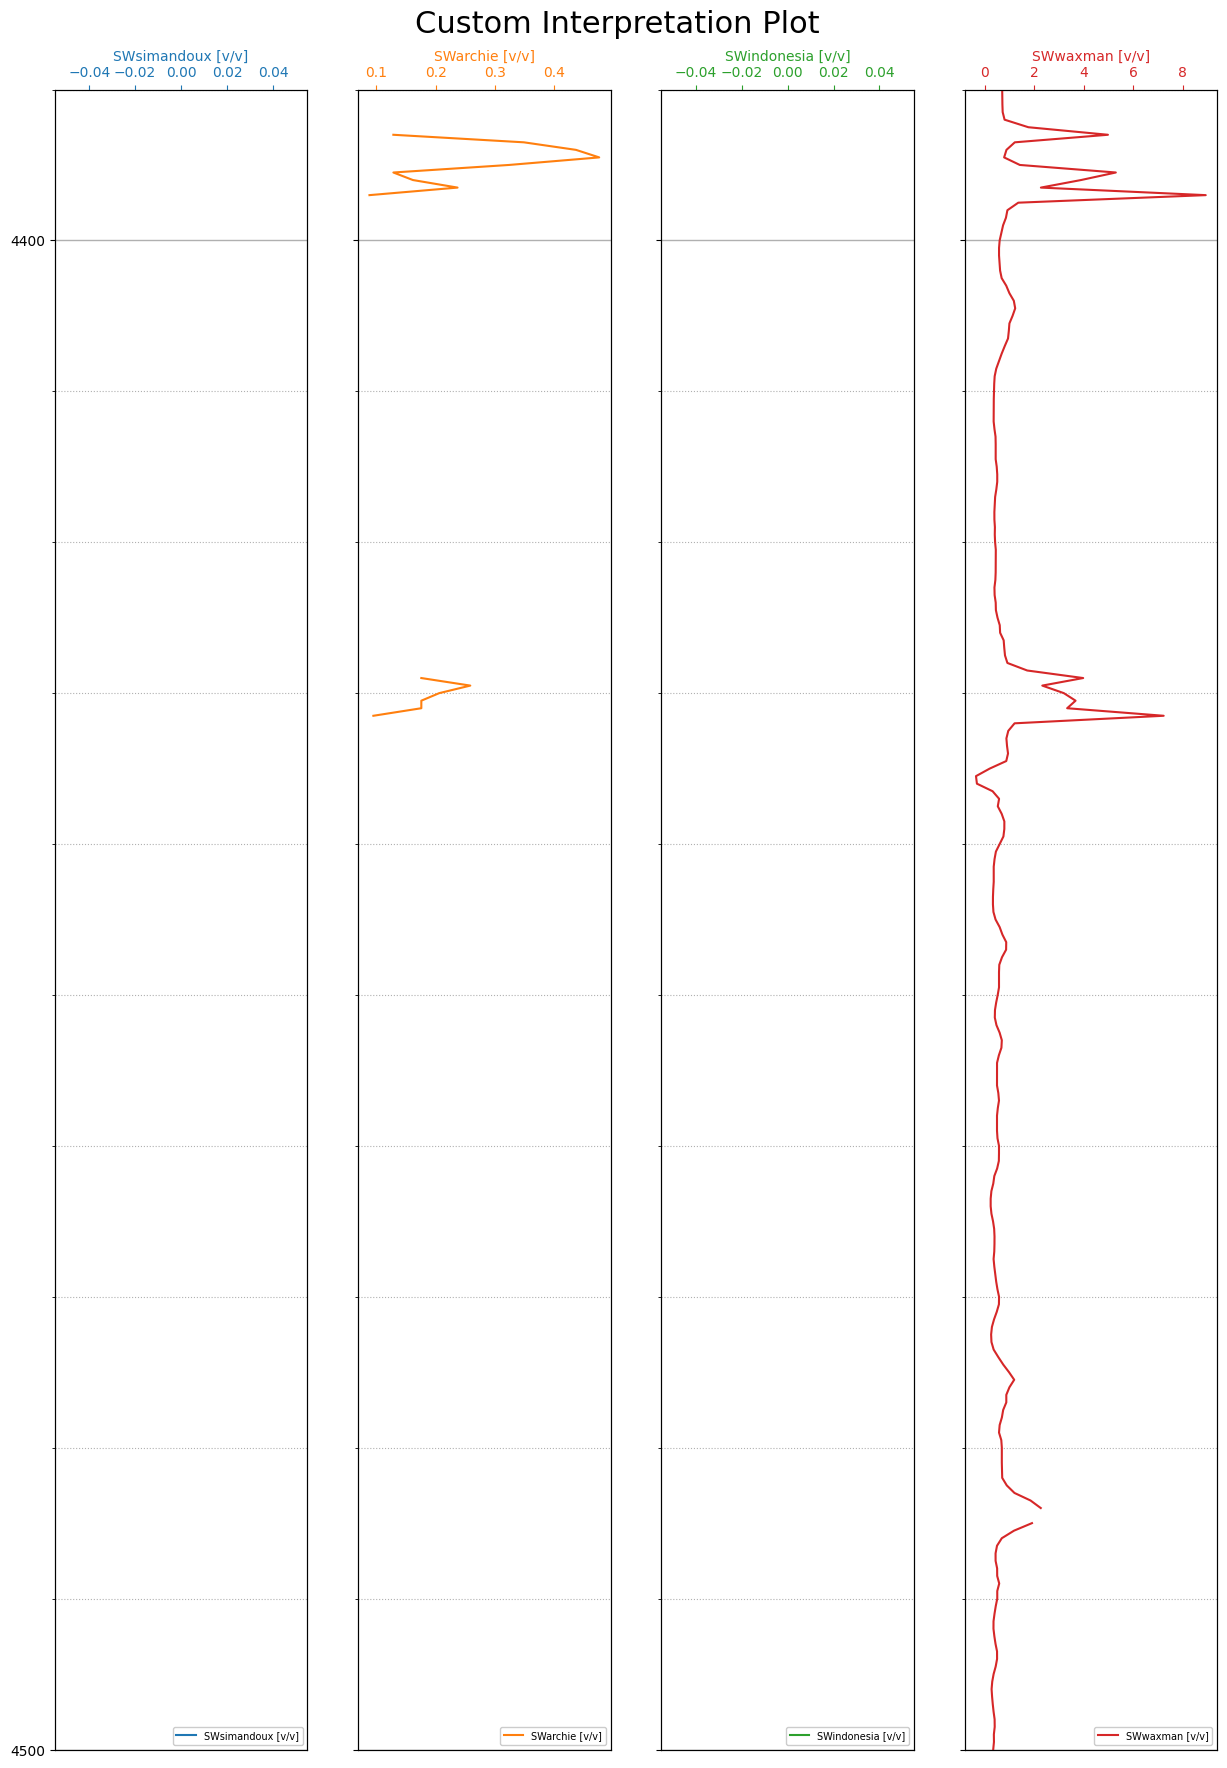

In [158]:
custom_interpretation_plot(logs, depth_start, depth_end, "SWsimandoux", "SWarchie", "SWindonesia", "SWwaxman", units=["v/v", "v/v", "v/v", "v/v"])

## **9. PERMEABILITY CALCULATION**

In [109]:
def perm_timur(phie,sw):
    perm = ((93*(phie**2.2))/sw)**2
    return perm

In [110]:
print(logs.columns)

Index(['WELL', 'DEPT', 'GR', 'MR', 'DR', 'SR', 'NPHI', 'RHOB', 'DT', 'VSH',
       'RW', 'core_por', 'core_perm', 'VCLGR', 'VCLND', 'VCLRT', 'VCL',
       'PHISw', 'PHISwshc', 'PHISrhg', 'PHISrhgshc', 'PHID', 'PHIDshc',
       'PHI_SIMANDOUX', 'PHIN', 'PHINshc', 'PHIxND', 'PHIE', 'SWarchie', 'BVW',
       'matrix', 'CEC', 'T', 'SWwaxman', 'SWindonesia', 'SWsimandoux'],
      dtype='object')


In [111]:
logs['PERMtimur'] = logs.apply(lambda row: perm_timur(row['PHIE'],row['SWarchie']), axis=1)

In [112]:
#drop logs["perm"] above 1000
logs = logs[logs["PERMtimur"] < 1000]

## **10. DISPLAY THE INTERPRETATION PLOT**
Create a plot template and add the results of volume of clay, saturation, permeability, and porosity.

In [113]:
def interpretation_plot(logs, depth_start, depth_end, GR_min, GR_max, DR_min, DR_max, MR_min, MR_max, SR_min, SR_max, RHOB_min, RHOB_max, NPHI_min, NPHI_max, perm,fill):
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12,20), sharey=True)
    fig.suptitle("Interpretation Plot", fontsize=22)
    fig.subplots_adjust(top=0.85,wspace=0.2)

    depth_range = depth_end - depth_start
    if depth_range > 5000:
      major_tick_interval = 1000
      minor_tick_interval = 100
    elif depth_range > 1000:
      major_tick_interval = 500
      minor_tick_interval = 50
    else:
      major_tick_interval = 100
      minor_tick_interval = 10

    #General setting for all axis
    for axes in ax:
        axes.set_ylim (depth_start,depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which='minor', linestyle=':')
        axes.yaxis.grid(True, which='major', linestyle='-', linewidth='1')
        axes.yaxis.set_major_locator(ticker.MultipleLocator(major_tick_interval))
        axes.yaxis.set_minor_locator(ticker.MultipleLocator(minor_tick_interval))
        axes.get_xaxis().set_visible(False)


    #1st track: GR, SP, CALI track
    if 'SP' in logs.columns:
      ax01=ax[0].twiny()
      if SP_min != "auto" and SP_max != "auto":
        ax01.set_xlim(SP_min,SP_max)
      ax01.plot(logs.SP, logs.DEPT, label='SP[mV]', color='blue')
      ax01.set_xlabel('SP[mV]',color='blue')
      ax01.tick_params(axis='x', colors='blue')
    if 'CALI' in logs.columns:
      ax02=ax[0].twiny()
      if CALI_min != "auto" and CALI_max != "auto":
        ax02.set_xlim(CALI_min,CALI_max)
      ax02.grid(True)
      ax02.plot(logs.CALI, logs.DEPT, '--', label='CALI[in]', color='black')
      ax02.spines['top'].set_position(('outward',40))
      ax02.set_xlabel('CALI[in]',color='black')
      ax02.tick_params(axis='x', colors='black')
    if 'GR' in logs.columns:
      ax03=ax[0].twiny()
      if GR_min != "auto" and GR_max != "auto":
        ax03.set_xlim(GR_min,GR_max)
      ax03.plot(logs.GR, logs.DEPT, label='GR[api]', color='green')
      ax03.spines['top'].set_position(('outward',80))
      ax03.set_xlabel('GR[api]',color='green')
      ax03.tick_params(axis='x', colors='green')



    #2nd track: Resistivities
    ax11=ax[1].twiny()
    if DR_min != "auto" and DR_max != "auto":
        ax11.set_xlim(DR_min,DR_max)
    ax11.set_xscale('log')
    ax11.grid(True, which="both")
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('DR[m.ohm]', color='red')
    ax11.plot(logs.DR, logs.DEPT, label='DR[m.ohm]', color='red')
    ax11.tick_params(axis='x', colors='red')

    ax12=ax[1].twiny()
    if MR_min != "auto" and MR_max != "auto":
        ax12.set_xlim(MR_min,MR_max)
    ax12.set_xscale('log')
    ax12.plot(logs.MR, logs.DEPT, label='MR[m.ohm]', color='purple')
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('MR[m.ohm]', color='purple')
    ax12.tick_params(axis='x', colors='purple')

    ax13=ax[1].twiny()
    if SR_min != "auto" and SR_max != "auto":
        ax13.set_xlim(SR_min,SR_max)
    ax13.set_xscale('log')
    ax13.plot(logs.SR, logs.DEPT, '--',label='SR[m.ohm]', color='black')
    ax13.spines['top'].set_position(('outward',0))
    ax13.set_xlabel('SR[m.ohm]',color='black')
    ax13.tick_params(axis='x', colors='black')



    #3rd track: DT, RHOB, NPHI track
    # ax21=ax[2].twiny()
    # ax21.grid(True)
    # if DT_min != "auto" and DT_max != "auto":
    #     ax21.set_xlim(DT_min,DT_max)
    # ax21.spines['top'].set_position(('outward',0))
    # ax21.set_xlabel('DT[us/ft]')
    # ax21.plot(logs.DT, logs.DEPT, label='DT[us/ft]', color='blue')
    # ax21.set_xlabel('DT[us/ft]', color='blue')
    # ax21.tick_params(axis='x', colors='blue')

    ax22=ax[2].twiny()
    if NPHI_min != "auto" and NPHI_max != "auto":
        ax22.set_xlim(NPHI_min,NPHI_max)
    ax22.invert_xaxis()
    ax22.plot(logs.NPHI, logs.DEPT, label='NPHI[%]', color='green')
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[%]', color='green')
    ax22.tick_params(axis='x', colors='green')

    ax23=ax[2].twiny()
    if RHOB_min != "auto" and RHOB_max != "auto":
        ax23.set_xlim(RHOB_min,RHOB_max)
    ax23.plot(logs.RHOB, logs.DEPT ,label='RHOB[g/cc]', color='red')
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('RHOB[g/cc]',color='red')
    ax23.tick_params(axis='x', colors='red')



    #4th track: SW
    ax31=ax[3].twiny()
    ax31.grid(True)
    ax31.set_xlim(1,0)
    if fill == "yes":
        # ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWwaxman,color='lightgreen',label='waxman - archie')
        # ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWindonesia,color='lightblue',label='indonesia - archie')
        ax31.fill_betweenx(logs.DEPT,logs.SWarchie,logs.SWsimandoux,color='red',label='simandoux - archie')
    ax31.plot(logs.SWarchie, logs.DEPT, label='SW[Archie]', color='black',linewidth=1)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('SW Archie [frac]', color='black')
    ax31.tick_params(axis='x', colors='black')

    # ax32=ax[3].twiny()
    # ax32.set_xlim(1,0)
    # ax32.plot(logs.SWwaxman, logs.DEPT, label="SW[Waxman]",color="red")
    # ax32.spines['top'].set_position(('outward',40))
    # ax32.set_xlabel('SW Waxman [frac]', color='red')
    # ax32.tick_params(axis='x', colors='red')

    # ax33=ax[3].twiny()
    # ax33.set_xlim(1,0)
    # ax33.plot(logs["SWindonesia"], logs.DEPT, label="SW[Indonesia]",color="blue")
    # ax33.spines['top'].set_position(('outward',80))
    # ax33.set_xlabel('SW Indonesia [frac]', color='blue')
    # ax33.tick_params(axis='x', colors='blue')

    ax32=ax[3].twiny()
    ax32.set_xlim(1,0)
    ax32.plot(logs["SWsimandoux"], logs.DEPT, label="SW[simandoux]",color="green")
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('SW simandoux [frac]', color='green')
    ax32.tick_params(axis='x', colors='green')


    #4th track: Permeability
    ax41=ax[4].twiny()
    ax41.plot(logs[perm], logs.DEPT, label="perm",color="green")
    ax41.spines['top'].set_position(('outward',0))
    ax41.set_xlabel('PERM [mD]', color='green')
    ax41.tick_params(axis='x', colors='green')

    ax42=ax[4].twiny()
    ax42.scatter(core_selected_data.core_perm, core_selected_data.DEPT, label='C_PERM', color='red',linewidths=0.5)
    ax42.spines['top'].set_position(('outward',40))
    ax42.set_xlabel('PERM-CORE', color='red')
    ax42.tick_params(axis='x', colors='red')



    #5th track: PHIE, BVW
    ax51=ax[5].twiny()
    ax51.grid(True)
    ax51.set_xlim(1,0)
    ax51.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black', linewidth=0.5, alpha=0.5)
    ax51.fill_betweenx(logs.DEPT,0,logs.BVW,color='lightblue', alpha=0.5)
    ax51.spines['top'].set_position(('outward',0))
    ax51.set_xlabel('PHIE-LOG', color='black')
    ax51.tick_params(axis='x', colors='black')

    ax52=ax[5].twiny()
    ax52.set_xlim(1,0)
    ax52.plot(logs.BVW, logs.DEPT, label='BVW', color='black', alpha=0.5)
    ax52.fill_betweenx(logs.DEPT,logs.PHIE, logs.BVW,color='green',alpha=0.2)
    ax52.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax52.spines['top'].set_position(('outward',40))
    ax52.set_xlabel('BVW', color='black')
    ax52.tick_params(axis='x', colors='black')

    ax53=ax[5].twiny()
    ax53.set_xlim(1,0)
    ax53.scatter(core_selected_data.core_por, core_selected_data.DEPT, label='C_PHIE', color='red',linewidths=0.5)
    ax53.spines['top'].set_position(('outward',80))
    ax53.set_xlabel('PHIE-CORE', color='red')
    ax53.tick_params(axis='x', colors='red')



    #6th track: PHIE, MATRIX, VCL
    ax60=ax[6].twiny()
    ax60.set_xlim(1,0)
    ax60.spines['top'].set_position(('outward',0))
    ax60.plot(logs.PHIE, logs.DEPT, label='PHIE', color='black',linewidth=0.5)
    ax60.set_xlabel('Porosity', color='blue')
    ax60.tick_params(axis='x', colors='blue')

    ax61=ax[6].twiny()
    ax61.set_xlim(0,1)
    ax61.spines['top'].set_position(('outward',40))
    ax61.plot(logs.VCL, logs.DEPT, label='VCL', color='green',linewidth=0.5)
    ax61.set_xlabel('VClay', color='green')
    ax61.tick_params(axis='x', colors='green')

    ax62=ax[6].twiny()
    ax62.set_xlim(1,0)
    ax62.spines['top'].set_position(('outward',80))
    ax62.fill_betweenx(logs.DEPT,0,logs.PHIE,color='lightgray',label='porosity')
    ax62.fill_betweenx(logs.DEPT,logs.PHIE,1-logs.VCL,color='orange',label='matrix')
    ax62.fill_betweenx(logs.DEPT,1-logs.VCL,1,color='lightgreen',label= 'Vclay')
    ax62.set_xlabel('Matrix', color='orange')
    ax62.tick_params(axis='x', colors='orange')
    ax62.legend(loc='lower left')


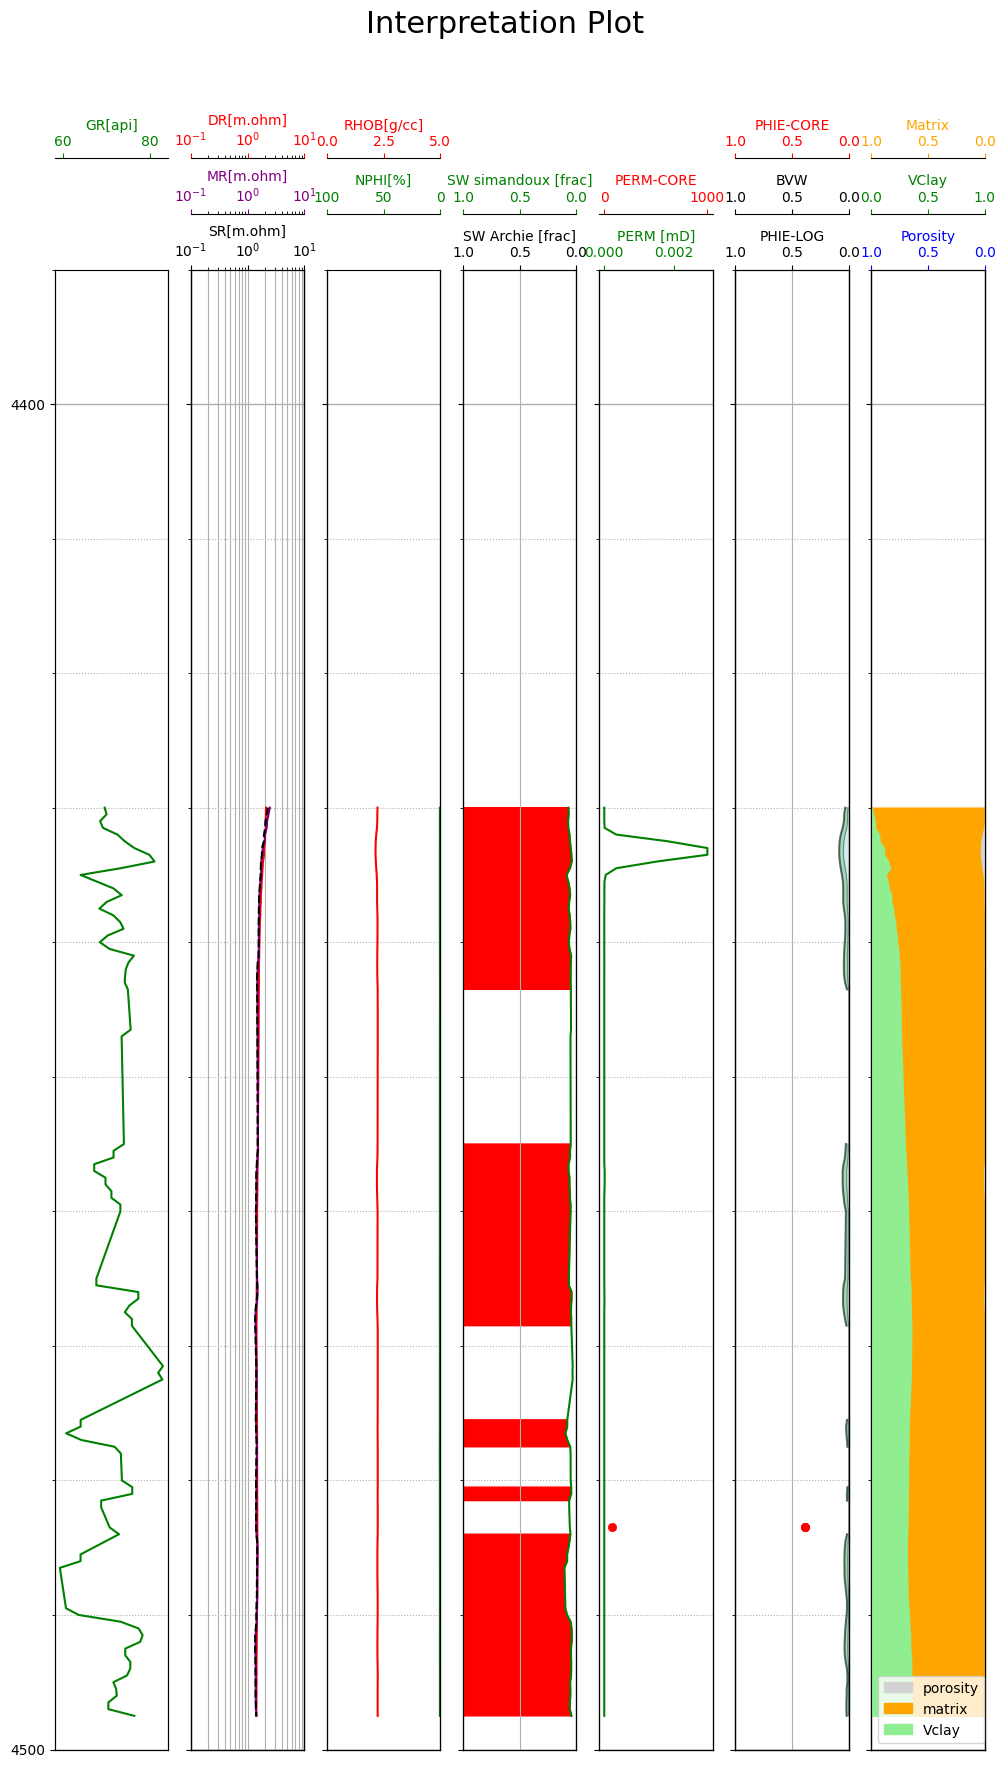

In [114]:
NPHI_max = 100
NPHI_min = 0
interpretation_plot(
    logs,
    depth_start,
    depth_end,
    # SP_min,
    # SP_max,
    # CALI_min,
    # CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    # DT_min,
    # DT_max,
    "PERMtimur",
    "yes"
    )

In [115]:
top_clean = 3865
bottom_clean = 3885
mean_waxman = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWwaxman"].mean()
mean_archie = logs[(logs['DEPT'] >= top_clean) & (logs['DEPT'] <= bottom_clean)]["SWarchie"].mean()
SW_coef = mean_archie/mean_waxman

In [116]:
logs["SWwaxman_corrected"] = logs["SWwaxman"] * SW_coef

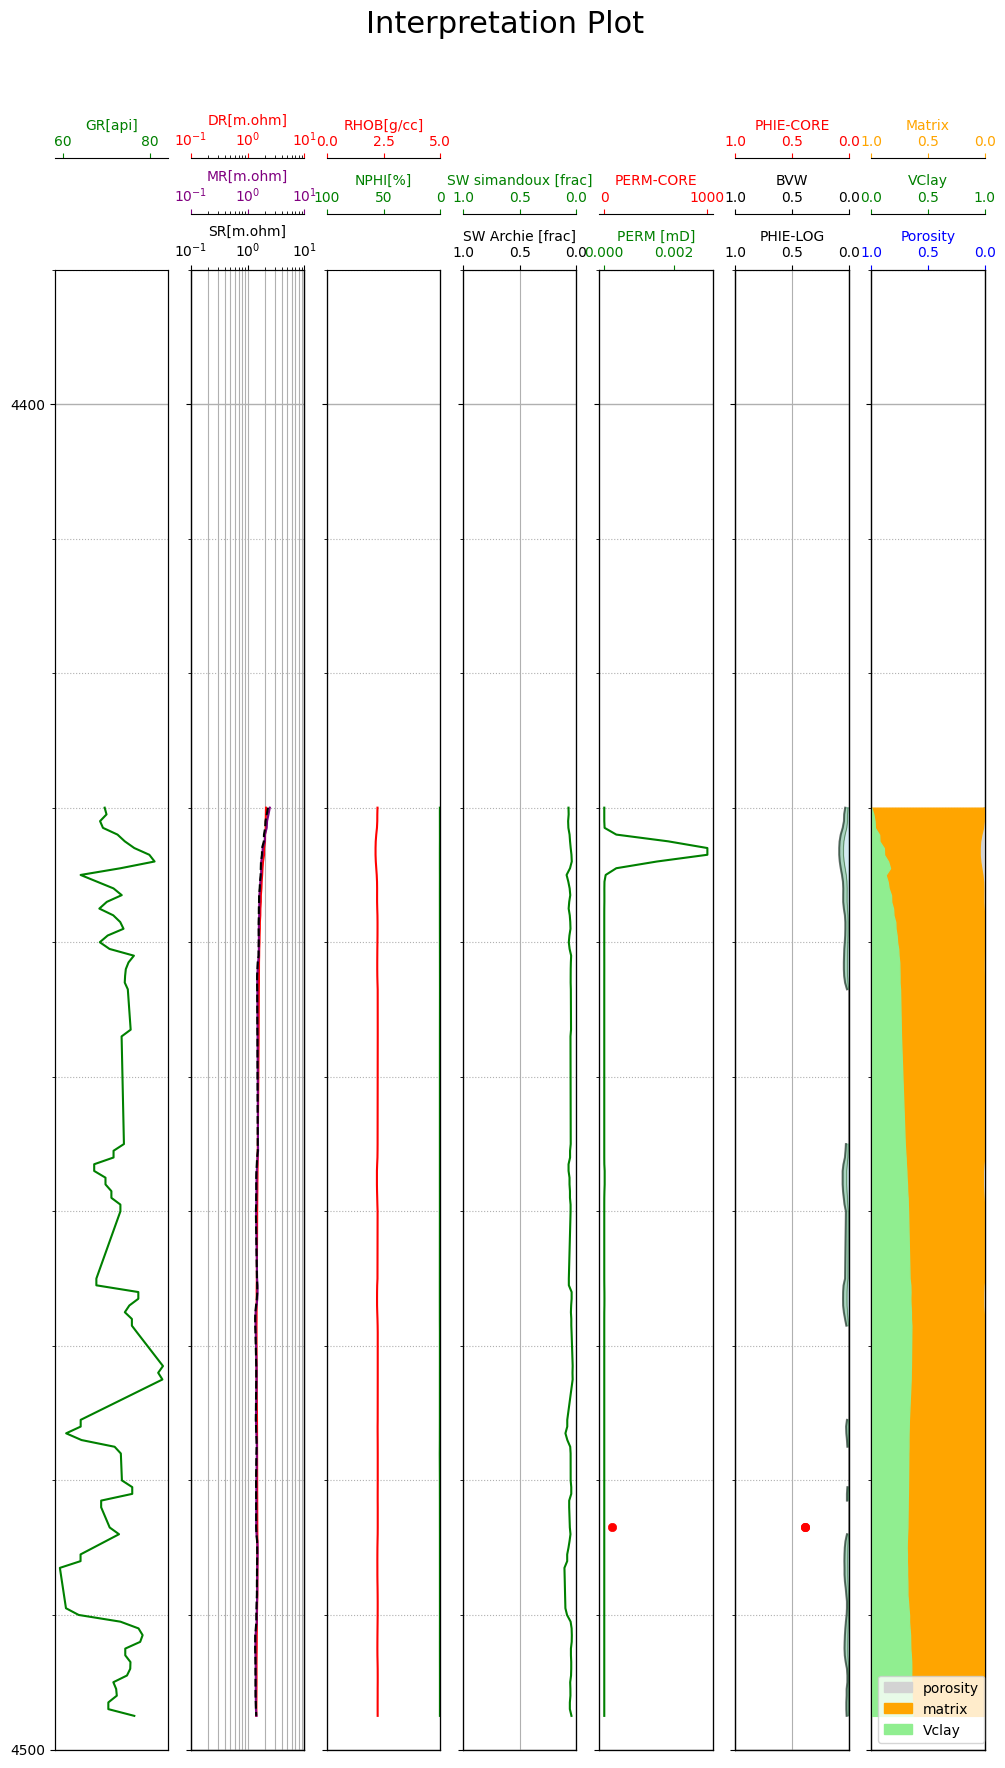

In [117]:
interpretation_plot(
    logs,
    depth_start,
    depth_end,
    # SP_min,
    # SP_max,
    # CALI_min,
    # CALI_max,
    GR_min,
    GR_max,
    DR_min,
    DR_max,
    MR_min,
    MR_max,
    SR_min,
    SR_max,
    RHOB_min,
    RHOB_max,
    NPHI_min,
    NPHI_max,
    # DT_min,
    # DT_max,
    "PERMtimur",
    "no"
    )

In [118]:
# Specify the file path where you want to save the Excel file
file_path = "output1.xlsx"

# Export the DataFrame to an Excel file
logs.to_excel(file_path, index=False)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")


DataFrame has been exported to output1.xlsx


## **11. OTHER**

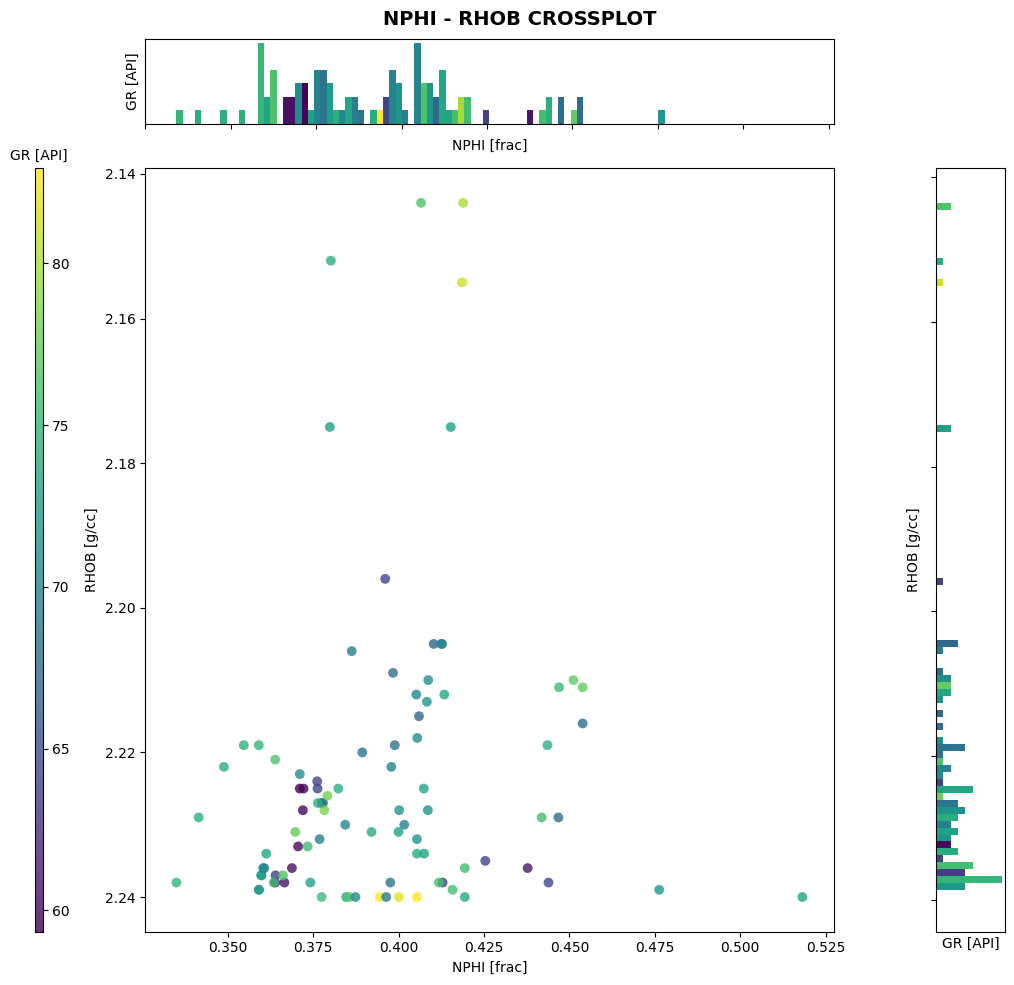

In [119]:
crossplott(logs,'NPHI','RHOB',"GR","frac","g/cc","API")

In [120]:
# crossplott(logs,'DT','RHOB',"GR","us/ft","g/cc","API")

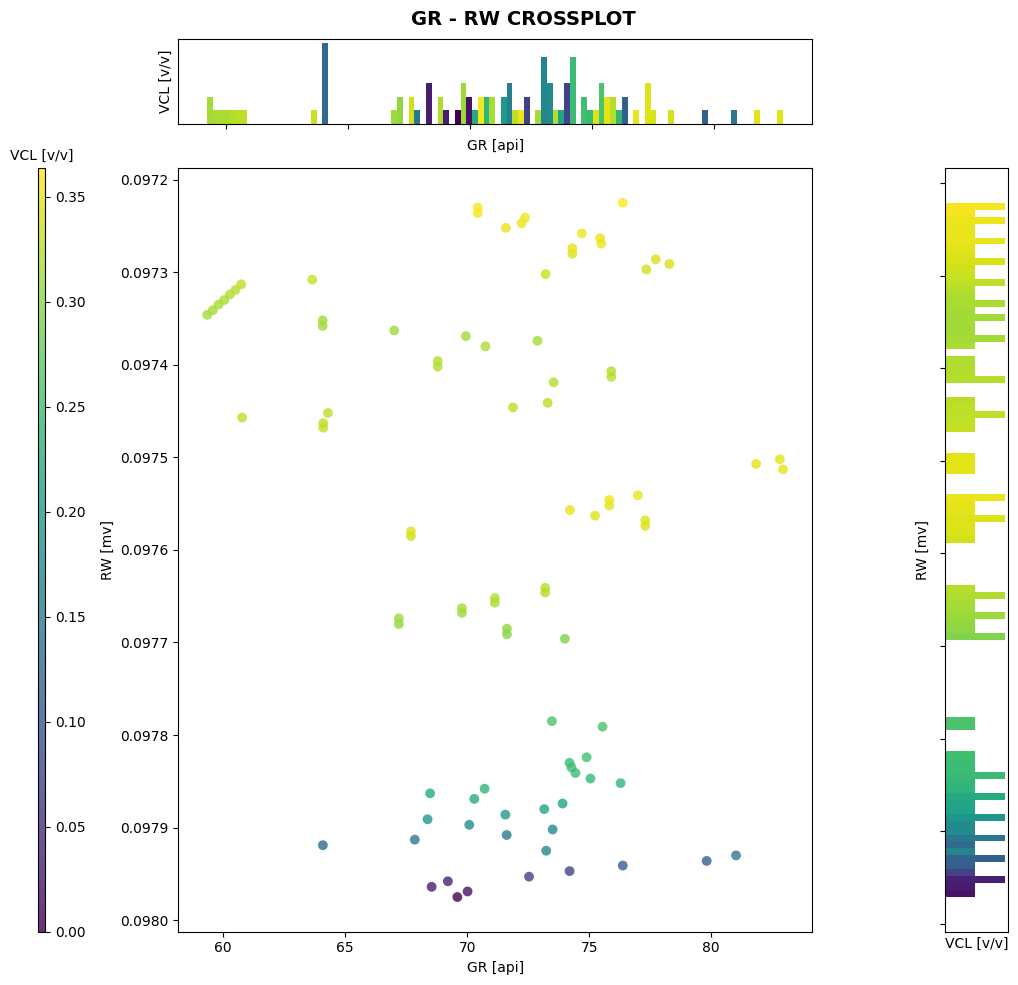

In [121]:
crossplott(logs,'GR','RW',"VCL","api","mv","v/v")

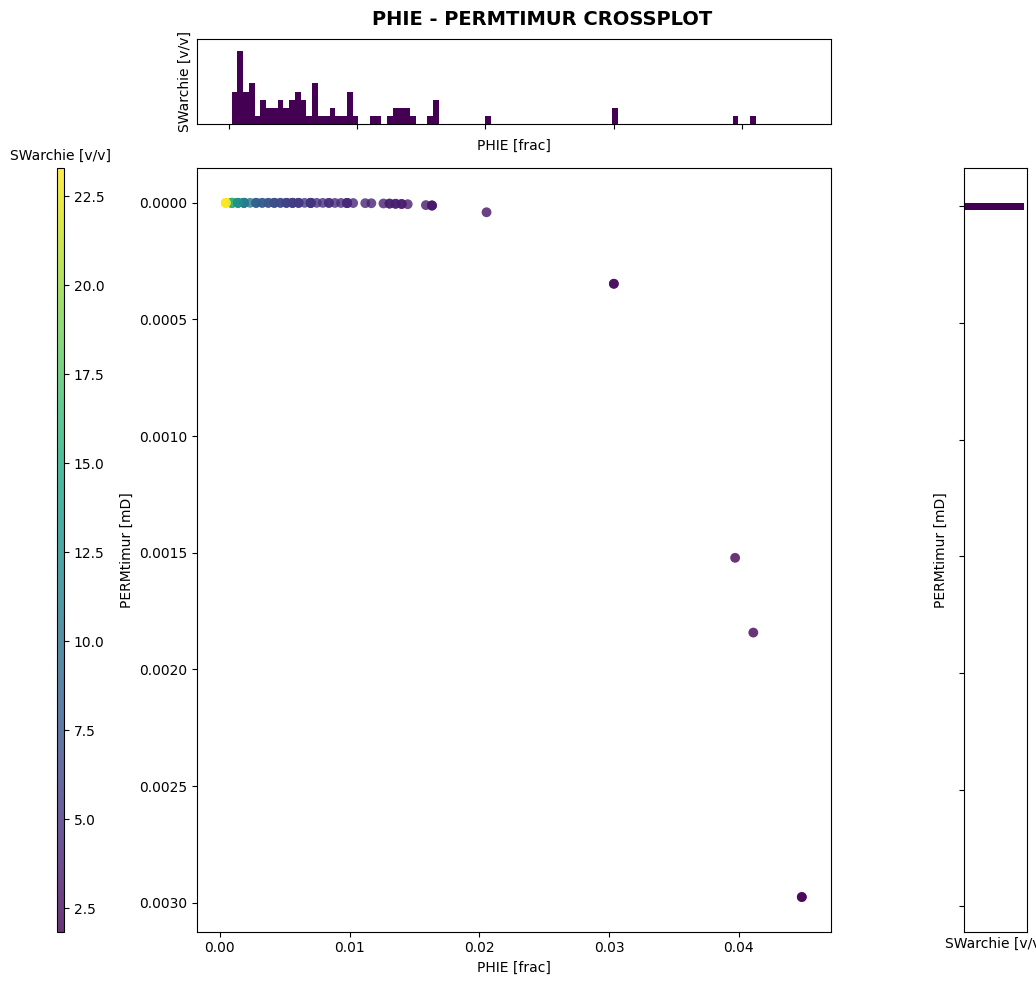

In [122]:
crossplott(logs,"PHIE","PERMtimur","SWarchie","frac","mD","v/v")